# **Intelligent Car Pricing: Building Syarah's Market Predictor**

**by: Faqih Asshiddik**

### **Contents**

1. Business Problem Understanding
2. Data Preparation
3. Preprocessing
4. Modeling
5. Remodeling
6. Conclusion
7. Recommendation

## **1. Business Problem Understanding**

#### **Context**

Syarah, an automotive marketplace in Saudi Arabia, facilitates thousands of used car transactions through their platform. While sellers currently have complete freedom in setting asking prices, this flexibility has led to market inefficiencies where pricing often relies on limited market knowledge rather than data-driven insights. Both buyers and sellers face challenges in determining fair market values, with buyers particularly struggling to evaluate price differences between similar vehicles.


#### **Business Problem**

The core challenge lies in the platform's pricing mechanism inefficiency. Without reliable pricing guidance:

1. Sellers risk either overpricing their vehicles, leading to extended listing times, or underpricing and losing potential value
2. Buyers struggle to evaluate if they're paying fair market value, leading to prolonged negotiation periods
3. The platform experiences reduced transaction efficiency due to misaligned price expectations between buyers and sellers

#### **Goals**

Our objective is to develop a machine learning model that will help Syarah provide accurate price predictions based on vehicle characteristics. The model aims to:

1. Provide sellers with data-driven price recommendations
2. Give buyers clear insights into fair market values
3. Increase user confidence through transparent pricing guidance

#### **Analytic Approach**

To address this pricing challenge, we will:

1. Analyze historical transaction data to understand price patterns
2. Build a regression model incorporating key vehicle features like make, year, mileage, options, and et cetera
3. Validate our predictions against actual market prices
4. Provide clear explanations of how different factors influence vehicle values



#### **Evaluation Metrics**

Success will be measured using:

1. Mean Absolute Percentage Error (MAPE): To understand our average prediction accuracy as a percentage, making it interpretable for business stakeholders
2. Root Mean Square Error (RMSE): To capture the magnitude of prediction errors in actual currency terms, helping assess practical impact

These metrics will help us evaluate the model's performance and ensure that it provides accurate price predictions for Syarah.

#### **Data Understanding**

The dataset used for this project is the Saudi Arabia Used Cars Dataset, which contains information about used cars listed for sale in Saudi Arabia. The dataset includes the following attributes:

| **Attribute** | **Data Type** | **Description** |
| --- | --- | --- |
| Type | Object | Type of used car |
| Region | Object | The region in which the used car was offered for sale |
| Make | Object | The company name |
| Gear_Type | Object | Gear type size of used car |
| Origin | Object | Origins of used car |
| Options | Object | Options of used car  |
| Year | Integer | Manufacturing year |
| Engine_Size | Float | The engine size of used car |
| Mileage | Integer | Mileage of used car |
| Negotiable | Bool | True if the price is 0, that means it it negotiable |
| Price | Integer | Used car price |

- Each row in the dataset represents a unique used car listing, and each column represents a specific attribute of the car that could influence its price.

- The Price column is the target variable, which the model will predict based on the other features.

- Understanding the relationship between these features (e.g., how Mileage or Year affects Price) is crucial for building an accurate pricing model.

In [1]:
# Import library
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/Users/faqihasshiddik/Desktop/file.csv/data_saudi_used_cars.csv')
df.head()

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5624 entries, 0 to 5623
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         5624 non-null   object 
 1   Region       5624 non-null   object 
 2   Make         5624 non-null   object 
 3   Gear_Type    5624 non-null   object 
 4   Origin       5624 non-null   object 
 5   Options      5624 non-null   object 
 6   Year         5624 non-null   int64  
 7   Engine_Size  5624 non-null   float64
 8   Mileage      5624 non-null   int64  
 9   Negotiable   5624 non-null   bool   
 10  Price        5624 non-null   int64  
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 445.0+ KB


## **2. Data Preparation**

Before diving into analysis, we needed to develop a deep understanding of our data's structure and quality. Our dataset captures various aspects of used car listings in Syarah, from basic vehicle characteristics to market positioning details. Each entry represents a unique vehicle listing, providing a snapshot of Syarah market.

### **2. 1. Data Unique Value**

In [4]:
listItem = []

for col in df.columns:
    listItem.append([
        col,                                          
        df[col].dtype,                               
        df[col].isna().sum(),                        
        df[col].nunique(),                           
        sorted(df[col].dropna().unique().tolist())   
    ])

df_desc = pd.DataFrame(
    data=listItem,
    columns=['Column_Name', 'Data_Type', 'Null_Count', 'Unique_Count', 'All_Unique_Values']
)

print('\nData Description: ')
df_desc


Data Description: 


,Column_Name,Data_Type,Null_Count,Unique_Count,All_Unique_Values
0,Type,object,0,347,"[2, 3, 300, 3008, 301, 360, 4Runner, 5, 500, 5..."
1,Region,object,0,27,"[Abha, Al-Ahsa, Al-Baha, Al-Jouf, Al-Medina, A..."
2,Make,object,0,58,"[Aston Martin, Audi, BMW, BYD, Bentley, Cadill..."
3,Gear_Type,object,0,2,"[Automatic, Manual]"
4,Origin,object,0,4,"[Gulf Arabic, Other, Saudi, Unknown]"
5,Options,object,0,3,"[Full, Semi Full, Standard]"
6,Year,int64,0,50,"[1963, 1964, 1965, 1975, 1977, 1978, 1979, 198..."
7,Engine_Size,float64,0,71,"[1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, ..."
8,Mileage,int64,0,1716,"[100, 104, 105, 106, 107, 108, 109, 110, 111, ..."
9,Negotiable,bool,0,2,"[False, True]"


Our initial examination revealed several areas requiring attention to ensure our model would be built on reliable data. For example, it reveals that while most numerical features like 'Price', 'Year', and 'Mileage' contain expected ranges of values, categorical features such as 'Make', 'Type', and 'Origin' include some inconsistencies that need addressing. This initial exploration forms the foundation for our cleaning steps.

### **2. 2. Data Cleaning**

#### **Column 'Origin'**

In [5]:
df['Origin'].unique()

array(['Saudi', 'Gulf Arabic', 'Other', 'Unknown'], dtype=object)

We encountered listings with 'Unknown' origins, representing vehicles whose manufacturing source wasn't clearly documented. Rather than discard this potentially valuable data, we reclassified these entries under an 'Other' category, preserving the information while acknowledging its uncertainty.

In [6]:
df[df['Origin'] == 'Unknown']

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
63,Land Cruiser Pickup,Qassim,Nissan,Manual,Unknown,Full,2016,4.8,42000,True,0
133,Land Cruiser,Riyadh,Toyota,Automatic,Unknown,Full,2014,4.6,191000,True,0
252,CX9,Abha,Mazda,Automatic,Unknown,Full,2012,2.5,377836,True,0
253,Sorento,Jubail,Kia,Automatic,Unknown,Semi Full,2015,3.3,133981,True,0
276,Charger,Riyadh,Dodge,Automatic,Unknown,Full,2020,3.6,9120,False,115000
...,...,...,...,...,...,...,...,...,...,...,...
5350,Sonata,Al-Ahsa,Hyundai,Automatic,Unknown,Semi Full,2016,2.4,258000,False,38000
5413,Camry,Riyadh,Toyota,Automatic,Unknown,Standard,2016,2.5,254000,True,0
5449,Land Cruiser,Tabouk,Toyota,Manual,Unknown,Full,1995,4.6,300000,False,20000
5481,Elantra,Al-Jouf,Hyundai,Automatic,Unknown,Standard,2016,2.0,120000,True,0


##### **Changing the value from 'Unknown' into 'Other' in 'Origin'**

In [7]:
df['Origin'] = np.where(df['Origin'] == 'Unknown', 'Other', df['Origin'])

#### **Column 'Type'**

In [8]:
df['Type'].unique()

array(['Corolla', 'Yukon', 'Range Rover', 'Optima', 'FJ', 'CX3',
       'Cayenne S', 'Sonata', 'Avalon', 'LS', 'C300', 'Land Cruiser',
       'Hilux', 'Tucson', 'Caprice', 'Sunny', 'Pajero', 'Azera', 'Focus',
       '5', 'Spark', 'Camry', 'Pathfinder', 'Accent', 'ML', 'Tahoe',
       'Yaris', 'Suburban', 'A', 'Altima', 'Traverse', 'Expedition',
       'Senta fe', 'Liberty', '3', 'X', 'Elantra', 'Land Cruiser Pickup',
       'VTC', 'Malibu', 'The 5', 'A8', 'Patrol', 'Grand Cherokee', 'SL',
       'Previa', 'SEL', 'Aveo', 'MKZ', 'Victoria', 'Datsun', 'Flex',
       'GLC', 'ES', 'Edge', '6', 'Escalade', 'Innova', 'Navara', 'H1',
       'G80', 'Carnival', 'Symbol', 'Camaro', 'Accord', 'Avanza',
       'Land Cruiser 70', 'Taurus', 'C5700', 'Impala', 'Optra', 'S',
       'Other', 'Cerato', 'Furniture', 'Murano', 'Explorer', 'LX',
       'Pick up', 'Charger', 'H6', 'BT-50', 'Hiace', 'Ranger', 'Fusion',
       'Rav4', 'Ciocca', 'CX9', 'Kona', 'Sentra', 'Sierra', 'Durango',
       'CT-S', 'Sylv

In [9]:
df[df['Type'] == 'Other']

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
115,Other,Jubail,Suzuki,Automatic,Saudi,Standard,2017,1.6,100,True,0
451,Other,Taef,Other,Automatic,Saudi,Full,2004,2.4,6000,True,0
663,Other,Qassim,Other,Manual,Other,Standard,1980,2.4,2500,False,220000
881,Other,Al-Baha,Other,Manual,Other,Standard,2020,1.1,2848,False,2000
969,Other,Riyadh,Other,Manual,Saudi,Standard,2006,6.5,81250,True,0
1186,Other,Dammam,Hyundai,Automatic,Other,Full,2011,4.6,270,False,30000
1199,Other,Qassim,Other,Manual,Other,Full,2019,8.0,24643,False,330000
1253,Other,Al-Medina,Other,Manual,Other,Standard,2009,2.4,1300,False,26000
1485,Other,Al-Ahsa,Suzuki,Manual,Other,Full,2014,1.0,25000,True,0
1629,Other,Jeddah,Other,Manual,Other,Semi Full,2021,1.2,3000,False,5500


In [10]:
df[df['Type'] == 'Other']['Price'].describe()

count        25.000000
mean      46320.000000
std      102417.434225
min           0.000000
25%           0.000000
50%        2000.000000
75%       30000.000000
max      375000.000000
Name: Price, dtype: float64

In [11]:
df[~(df['Type'] == 'Other')]['Price'].describe()

count      5599.000000
mean      53104.215574
std       69989.834229
min           0.000000
25%           0.000000
50%       36500.000000
75%       73000.000000
max      850000.000000
Name: Price, dtype: float64

The 'Type' field included a small subset (25 vehicles) labeled as 'Other'. We found these entries showed significantly different pricing patterns from the main dataset:

- Average price: 46,320 SAR (compared to 53,104 SAR for defined types)
- Extremely high price variance
- Unusually low median price (2,000 SAR)

Given these characteristics and the small sample size, we determined these entries would likely introduce noise into our model and removed them from our dataset.

##### **Removing the value of 'Other' in 'Type'**

In [12]:
df[df['Type'] != 'Other']

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0
...,...,...,...,...,...,...,...,...,...,...,...
5619,X-Trail,Jeddah,Nissan,Automatic,Saudi,Standard,2018,2.5,78794,False,68000
5620,Altima,Jeddah,Nissan,Automatic,Saudi,Semi Full,2020,2.5,58000,True,0
5621,Yukon,Dammam,GMC,Automatic,Saudi,Full,2016,5.3,48000,False,145000
5622,RX,Dammam,Lexus,Automatic,Gulf Arabic,Full,2016,2.5,81000,False,154000


#### **Column 'Make'**

In [13]:
df['Make'].unique()

array(['Toyota', 'GMC', 'Land Rover', 'Kia', 'Mazda', 'Porsche',
       'Hyundai', 'Lexus', 'Chrysler', 'Chevrolet', 'Nissan',
       'Mitsubishi', 'Ford', 'MG', 'Mercedes', 'Jeep', 'BMW', 'Audi',
       'Lincoln', 'Cadillac', 'Genesis', 'Renault', 'Honda', 'Suzuki',
       'Zhengzhou', 'Dodge', 'HAVAL', 'INFINITI', 'Isuzu', 'Changan',
       'Aston Martin', 'Mercury', 'Great Wall', 'Other', 'Rolls-Royce',
       'MINI', 'Volkswagen', 'BYD', 'Geely', 'Victory Auto', 'Classic',
       'Jaguar', 'Daihatsu', 'Maserati', 'Hummer', 'GAC', 'Lifan',
       'Bentley', 'Chery', 'Peugeot', 'Foton', 'Škoda', 'Fiat', 'Iveco',
       'SsangYong', 'FAW', 'Tata', 'Ferrari'], dtype=object)

In [14]:
df[df['Make'] == 'Other']

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
451,Other,Taef,Other,Automatic,Saudi,Full,2004,2.4,6000,True,0
663,Other,Qassim,Other,Manual,Other,Standard,1980,2.4,2500,False,220000
881,Other,Al-Baha,Other,Manual,Other,Standard,2020,1.1,2848,False,2000
969,Other,Riyadh,Other,Manual,Saudi,Standard,2006,6.5,81250,True,0
1199,Other,Qassim,Other,Manual,Other,Full,2019,8.0,24643,False,330000
1253,Other,Al-Medina,Other,Manual,Other,Standard,2009,2.4,1300,False,26000
1629,Other,Jeddah,Other,Manual,Other,Semi Full,2021,1.2,3000,False,5500
1752,Other,Khobar,Other,Manual,Other,Semi Full,2019,2.4,1000,True,0
2595,Other,Jazan,Other,Manual,Other,Standard,2011,2.4,100000,True,0
3789,Other,Riyadh,Other,Automatic,Saudi,Full,2009,2.4,218000,True,0


In [15]:
df[df['Make'] == 'Other']['Price'].describe()

count        10.000000
mean      58350.000000
std      117361.277449
min           0.000000
25%           0.000000
50%        1000.000000
75%       20875.000000
max      330000.000000
Name: Price, dtype: float64

In [16]:
df[~(df['Make'] == 'Other')]['Price'].describe()

count      5614.000000
mean      53064.660314
std       70060.014802
min           0.000000
25%           0.000000
50%       36500.000000
75%       72977.500000
max      850000.000000
Name: Price, dtype: float64

Similar analysis of the 'Make' field revealed 10 vehicles classified as 'Other'. Statistical analysis showed these entries had:

- A mean price drastically different from the main dataset
- Standard deviation of 117,361 SAR, indicating unstable pricing patterns
- Significant discrepancy between mean and median prices

These characteristics suggested these entries might represent data entry errors or special cases, therefore we decide to remove it.

##### **Removing the value of 'Other' in 'Make'**

In [17]:
df[df['Make'] != 'Other']

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0
...,...,...,...,...,...,...,...,...,...,...,...
5619,X-Trail,Jeddah,Nissan,Automatic,Saudi,Standard,2018,2.5,78794,False,68000
5620,Altima,Jeddah,Nissan,Automatic,Saudi,Semi Full,2020,2.5,58000,True,0
5621,Yukon,Dammam,GMC,Automatic,Saudi,Full,2016,5.3,48000,False,145000
5622,RX,Dammam,Lexus,Automatic,Gulf Arabic,Full,2016,2.5,81000,False,154000


#### **Check for missing value**

In [18]:
df.isna().sum()

Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

We confirmed we had no missing values in our dataset

#### **Check for duplicated data**

In [19]:
df.duplicated().sum()

4

We removed duplicate entries, ensuring each vehicle listing was unique

In [20]:
df.drop_duplicates(inplace = True)

### **2. 3. EDA & Outliers Detection**

#### **2. 3. 1. Price Distribution**

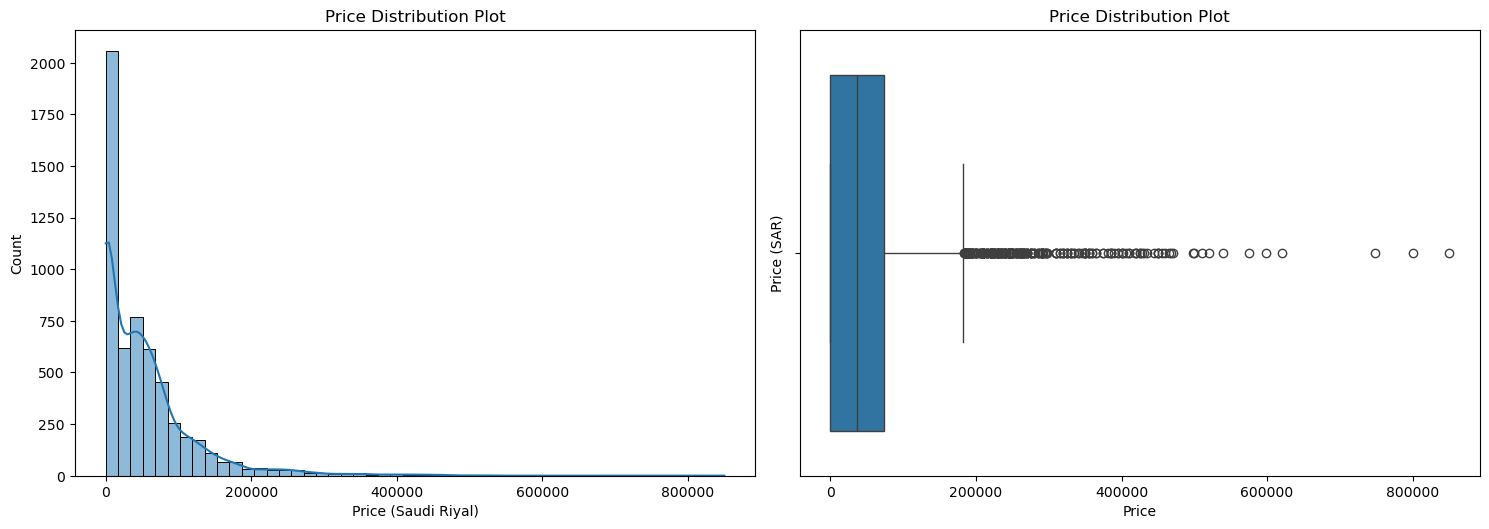

In [21]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(data = df, x = 'Price', bins = 50, kde = True)
plt.title('Price Distribution Plot')
plt.xlabel('Price (Saudi Riyal)')
plt.ylabel('Count')

plt.subplot(2, 2, 2)
sns.boxplot(data = df, x = 'Price', )
plt.title('Price Distribution Plot')
plt.ylabel('Price (SAR)')
plt.tight_layout();

We observed numerous entries with 0 SAR prices, which needed to be addressed first, these zero prices are problematic because they don't represent actual market transactions and including them would significantly skew our model's ability to learn real price patterns.

We set 5,000 SAR as our lower threshold because the very low prices could indicate data entry errors. While the 200,000 SAR threshold helps maintain focus on the most common price ranges where most transactions occur

So we established a price range of 5,000 to 200,000 SAR, this range captures the vast majority of legitimate transactions while excluding extreme values that likely represent data entry errors or special cases.

##### **Removing the extreme outliers in 'Price'**

In [22]:
print(f'\nOriginal price distribution: {df['Price'].describe()}')
df = df[(df['Price']>= 5000) & (df['Price'] <= 200000)]
print(f'\nFiltered price distribution: {df['Price'].describe()}')


Original price distribution: count      5620.000000
mean      53086.404448
std       70175.153207
min           0.000000
25%           0.000000
50%       36500.000000
75%       73000.000000
max      850000.000000
Name: Price, dtype: float64

Filtered price distribution: count      3536.000000
mean      65527.294400
std       40867.265659
min        5000.000000
25%       35000.000000
50%       55000.000000
75%       85000.000000
max      200000.000000
Name: Price, dtype: float64


##### **Updated dataset of 'Price'**

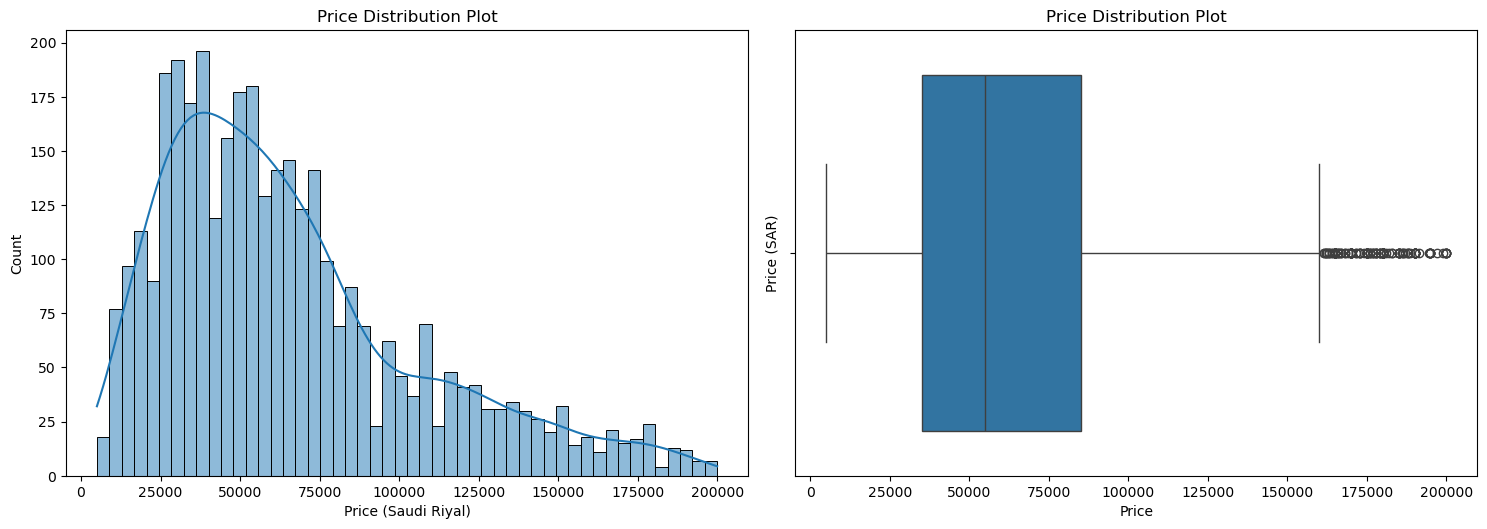

In [23]:
plt.figure(figsize=(15, 10))

plt.subplot(2,2,1)
sns.histplot(data = df, x = 'Price', bins = 50, kde = True)
plt.title('Price Distribution Plot')
plt.xlabel('Price (Saudi Riyal)')
plt.ylabel('Count')

plt.subplot(2,2,2)
sns.boxplot(data = df, x = 'Price')
plt.title('Price Distribution Plot')
plt.ylabel('Price (SAR)')
plt.tight_layout();

After applying our 5,000-200,000 SAR filter:

- The distribution became more normalized
- Mean and median values moved closer together
- Standard deviation decreased to more reasonable levels

#### **2. 3. 2. Year Distribution**

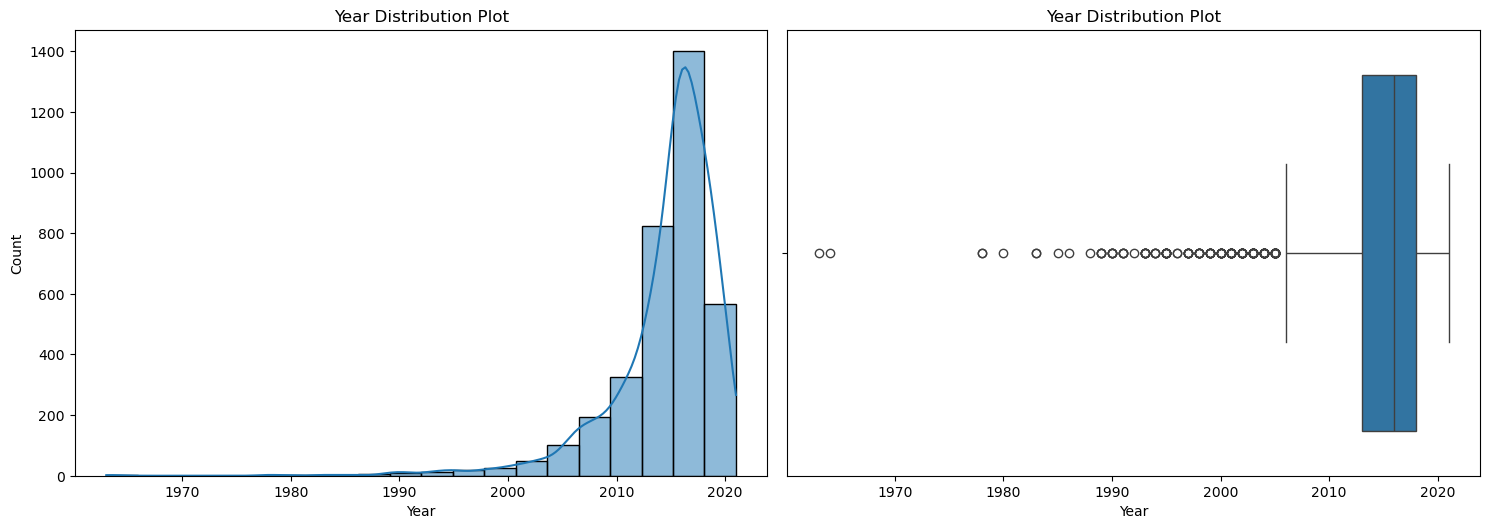

In [24]:
plt.figure(figsize=(15, 10))

plt.subplot(2,2,1)
sns.histplot(data = df, x = 'Year', bins = 20, kde = True)
plt.title('Year Distribution Plot')
plt.xlabel('Year')
plt.ylabel('Count')

plt.subplot(2,2,2)
sns.boxplot(data = df, x = 'Year')
plt.title('Year Distribution Plot')
plt.tight_layout();

##### **Removing the extreme outliers in 'Year'**

In [25]:
print(f'Number of dataset with Year is betwen 2000 and 2021: {df[(df['Year'] >= 2000) & (df['Year'] <= 2021)].shape[0]}')

# Filter years
df = df[(df['Year'] >= 2000) & (df['Year'] <= 2021)]

Number of dataset with Year is betwen 2000 and 2021: 3466


For the 'Year' feature, we limit our data to vehicles from 2000 to 2021.

The lower bound of 2000 was chosen because:
- Cars older than 2000 (over 20 years old at the time of data collection) typically represent a different market segment, often being collectibles or project cars
- Vehicles this old frequently have incomplete maintenance histories and unreliable pricing patterns

The upper bound of 2021 was selected because:
- This represents the most recent complete model year in our dataset

This decision balances the need to include older vehicles that are still actively traded in the market while excluding vintage cars that might follow different pricing patterns. This range ensures our model focuses on the most relevant and active segments of the used car market.

##### **Updated dataset of 'Year'**

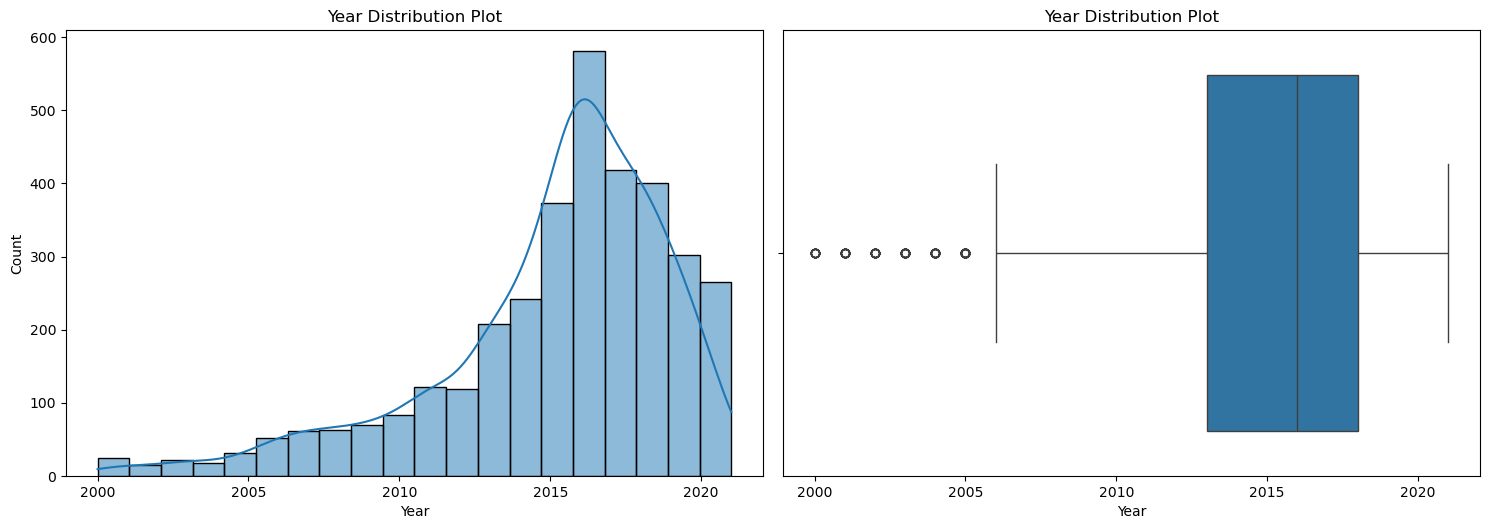

In [26]:
plt.figure(figsize=(15, 10))

plt.subplot(2,2,1)
sns.histplot(data = df, x = 'Year', bins = 20, kde = True)
plt.title('Year Distribution Plot')
plt.xlabel('Year')
plt.ylabel('Count')
plt.gca().xaxis.set_major_formatter('{:.0f}'.format)

plt.subplot(2,2,2)
sns.boxplot(data = df, x = 'Year')
plt.title('Year Distribution Plot')
plt.gca().xaxis.set_major_formatter('{:.0f}'.format)
plt.tight_layout();

#### **2. 3. 3. Mileage Distribution**

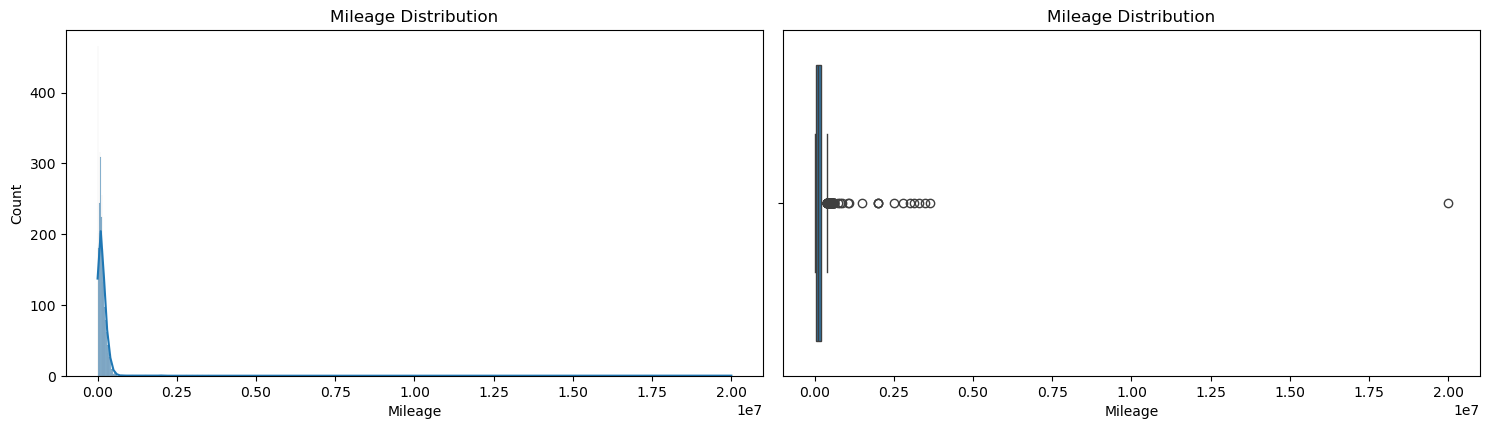

In [27]:
plt.figure(figsize=(15, 8))

# Mileage Hist Plot
plt.subplot(2, 2, 1)
sns.histplot(data = df, x = 'Mileage', kde = True)
plt.title('Mileage Distribution')
plt.xlabel('Mileage')

# Mileage Box Plot
plt.subplot(2, 2, 2)
sns.boxplot(data = df, x='Mileage')
plt.title('Mileage Distribution')
plt.xlabel('Mileage')
plt.tight_layout();

In [28]:
df['Mileage'].describe()

count    3.466000e+03
mean     1.465639e+05
std      3.845839e+05
min      1.000000e+02
25%      5.500000e+04
50%      1.090000e+05
75%      1.900000e+05
max      2.000000e+07
Name: Mileage, dtype: float64

We set our mileage cutoff at 575,000 kilometers based on distribution and practical considerations:

- The average annual mileage in Saudi Arabia typically ranges between 20,000 to 25,000 kilometers
- For a 20-year-old car (our maximum age cutoff), this would suggest a reasonable maximum of around 500,000 kilometers
- The 575,000 kilometer threshold represents approximately the 95th percentile of our mileage distribution

This threshold was chosen based on practical considerations of vehicle longevity and reliability of data entries.

##### **Removing the extreme outliers in 'Mileage'**

In [29]:
print(f'Number of dataset with Mileage over 575000: {df[df['Mileage'] > 575000].shape[0]}')

# Drop Mileage > 575000
df = df[df['Mileage'] < 575000]

Number of dataset with Mileage over 575000: 21


##### **Updated dataset of 'Mileage'**

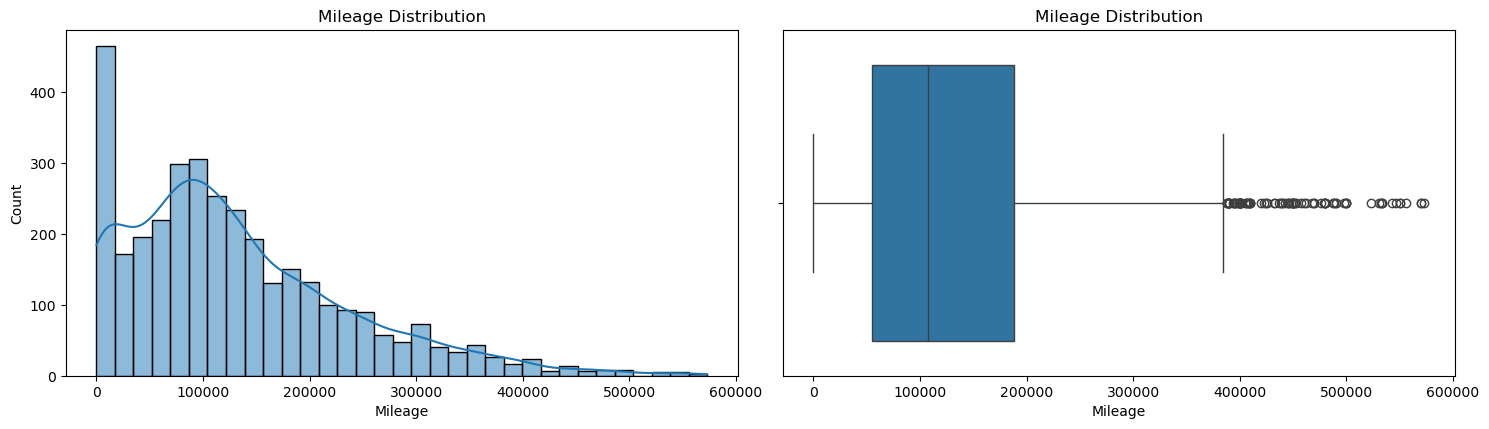

In [30]:
plt.figure(figsize=(15, 8))

# Mileage Hist Plot
plt.subplot(2, 2, 1)
sns.histplot(data = df, x = 'Mileage', kde = True)
plt.title('Mileage Distribution')
plt.xlabel('Mileage')

# Mileage Box Plot
plt.subplot(2, 2, 2)
sns.boxplot(data = df, x='Mileage')
plt.title('Mileage Distribution')
plt.xlabel('Mileage')
plt.tight_layout();

After applying the 575,000 km cutoff, we maintained a natural right-skewed distribution (which is expected for mileage data) while removing extreme outliers

#### **2. 3. 4. Make Analysis**

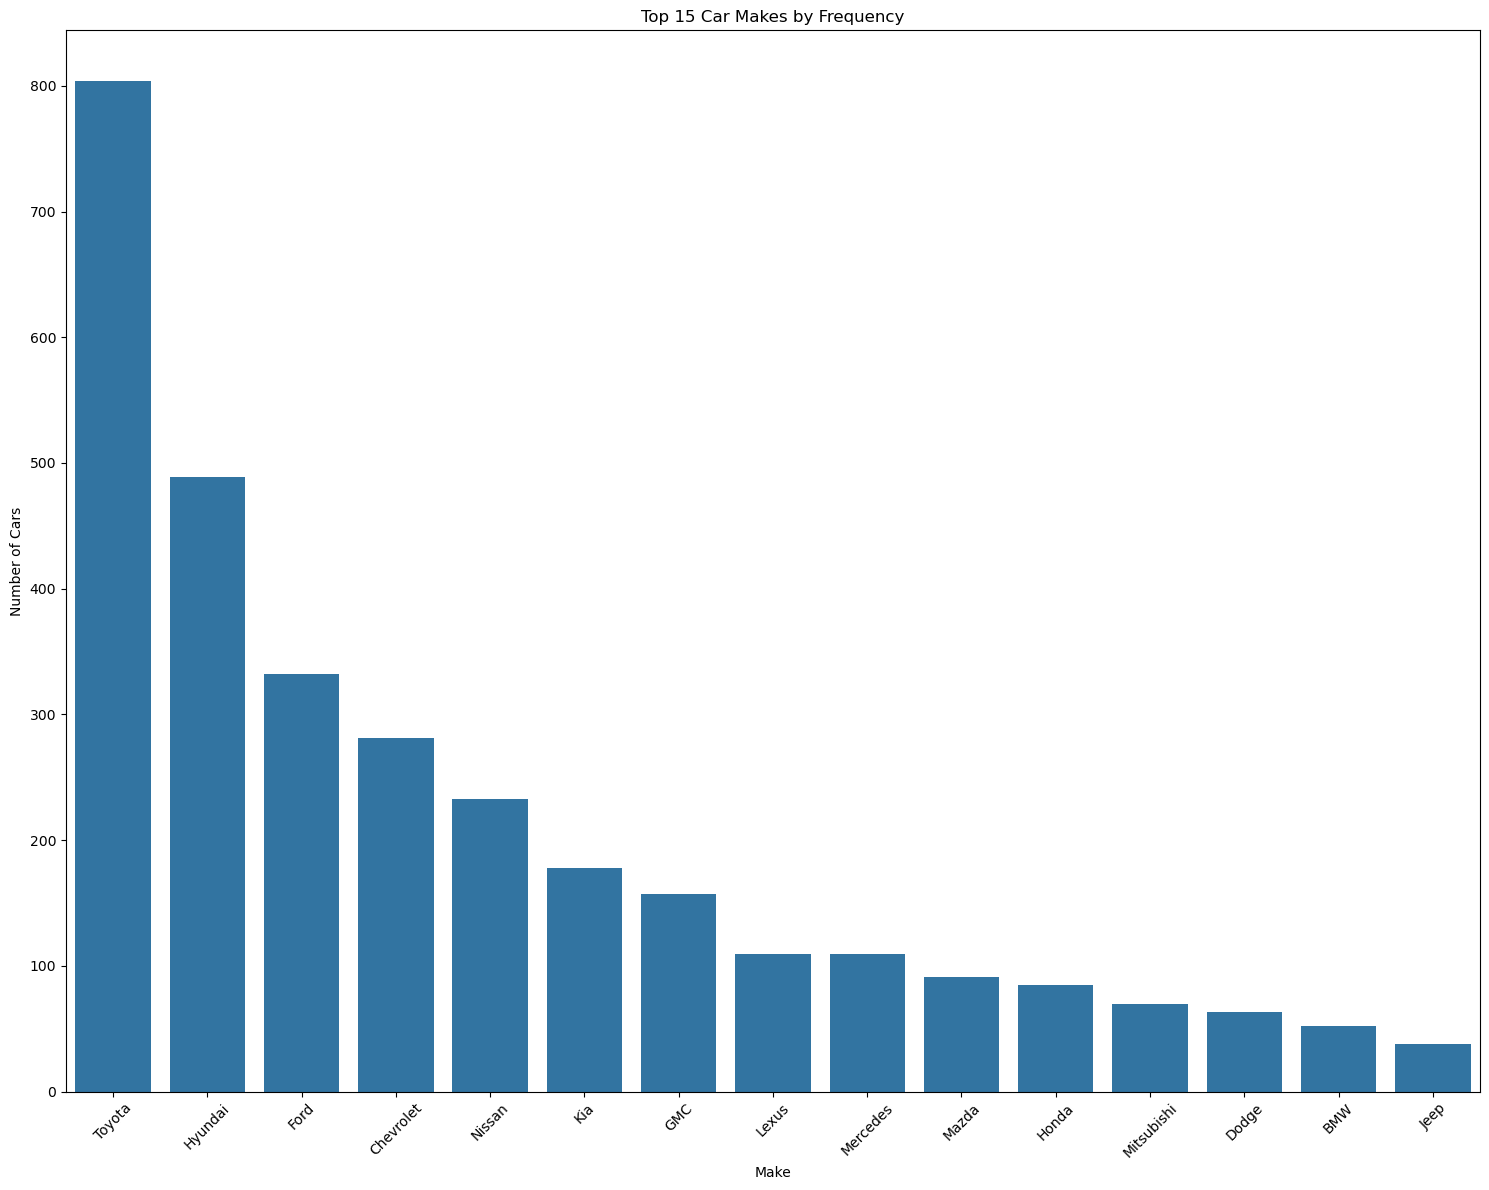

In [31]:
plt.figure(figsize = (15, 12))

top_makes = df['Make'].value_counts().head(15)
sns.barplot(x = top_makes.index, y = top_makes.values)
plt.title('Top 15 Car Makes by Frequency')
plt.xticks(rotation = 45)
plt.ylabel('Number of Cars')
plt.tight_layout();

In [32]:
df['Make'].value_counts()

Make
Toyota          804
Hyundai         489
Ford            332
Chevrolet       281
Nissan          233
Kia             178
GMC             157
Lexus           109
Mercedes        109
Mazda            91
Honda            85
Mitsubishi       70
Dodge            63
BMW              52
Jeep             38
Chrysler         36
Genesis          27
Renault          25
Audi             24
Land Rover       24
Changan          24
Cadillac         21
Geely            19
Volkswagen       16
MG               15
Isuzu            12
Porsche          10
INFINITI         10
Suzuki           10
Lincoln           9
HAVAL             9
Jaguar            8
Peugeot           7
MINI              7
Mercury           7
Fiat              6
GAC               3
FAW               3
Daihatsu          3
Zhengzhou         2
Other             2
Hummer            2
Maserati          2
Foton             2
Aston Martin      1
Iveco             1
Škoda             1
Victory Auto      1
BYD               1
Chery          

We analyzed the distribution of car manufacturers and implemented a threshold of ≤10 instances for grouping into 'Others' because:

- Makes with fewer than 10 instances don't provide enough data points for reliable pattern learning
- Maintaining too many rare manufacturers could lead to overfitting
- The simplified categorization helps our model focus on the most common brands in the Saudi market

##### **Grouping 'Make' value that have < 10 values into Others**

In [33]:
df_make = df['Make'].value_counts().reset_index().rename(columns = {'index' : 'Make', 
                                                                    'Make ' : 'Count'})
df_make

,Make,count
0,Toyota,804
1,Hyundai,489
2,Ford,332
3,Chevrolet,281
4,Nissan,233
5,Kia,178
6,GMC,157
7,Lexus,109
8,Mercedes,109
9,Mazda,91


In [34]:
df['Make'] = np.where(df['Make'].isin(df_make[df_make['count'] <= 10]['Make'].values), 'Others', df['Make'])

##### **Updated dataset of 'Make'**

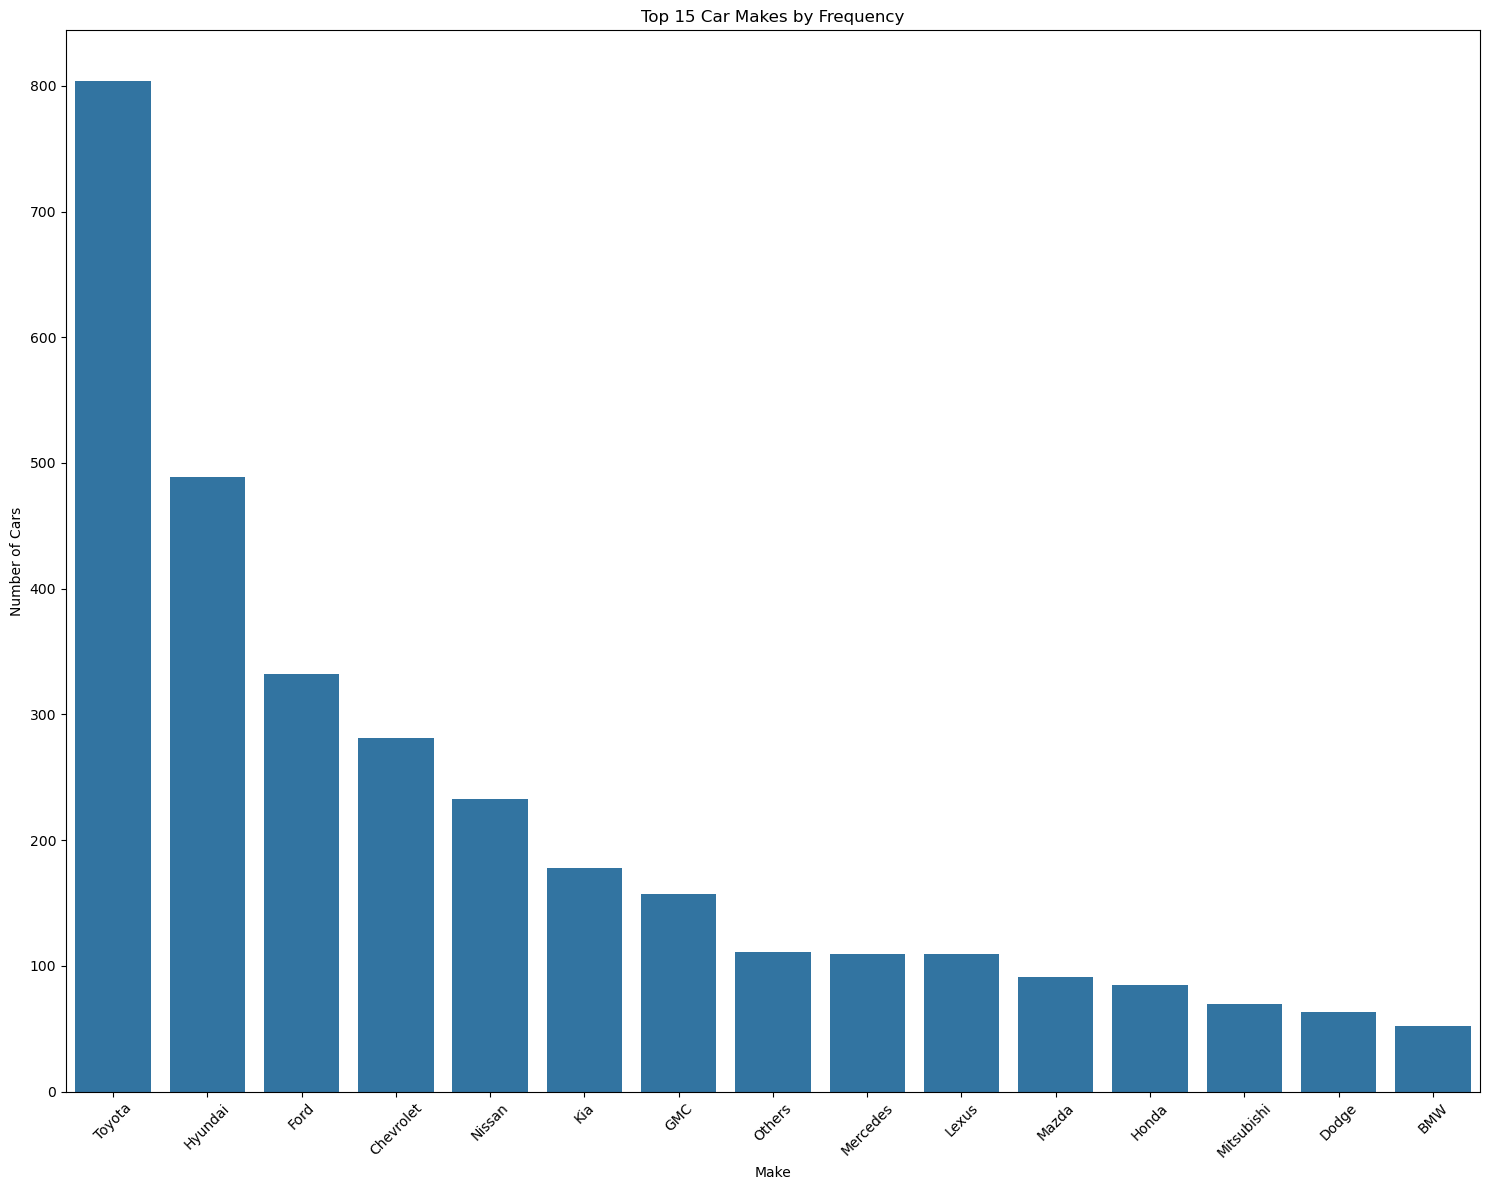

In [35]:
plt.figure(figsize = (15, 12))

top_makes = df['Make'].value_counts().head(15)
sns.barplot(x = top_makes.index, y = top_makes.values)
plt.title('Top 15 Car Makes by Frequency')
plt.xticks(rotation = 45)
plt.ylabel('Number of Cars')
plt.tight_layout();

Post-grouping visualization showed clearer patterns of market representation with Toyota, Hyundai, and Ford as dominant brands

#### **2. 3. 5. Engine Size Analysis**

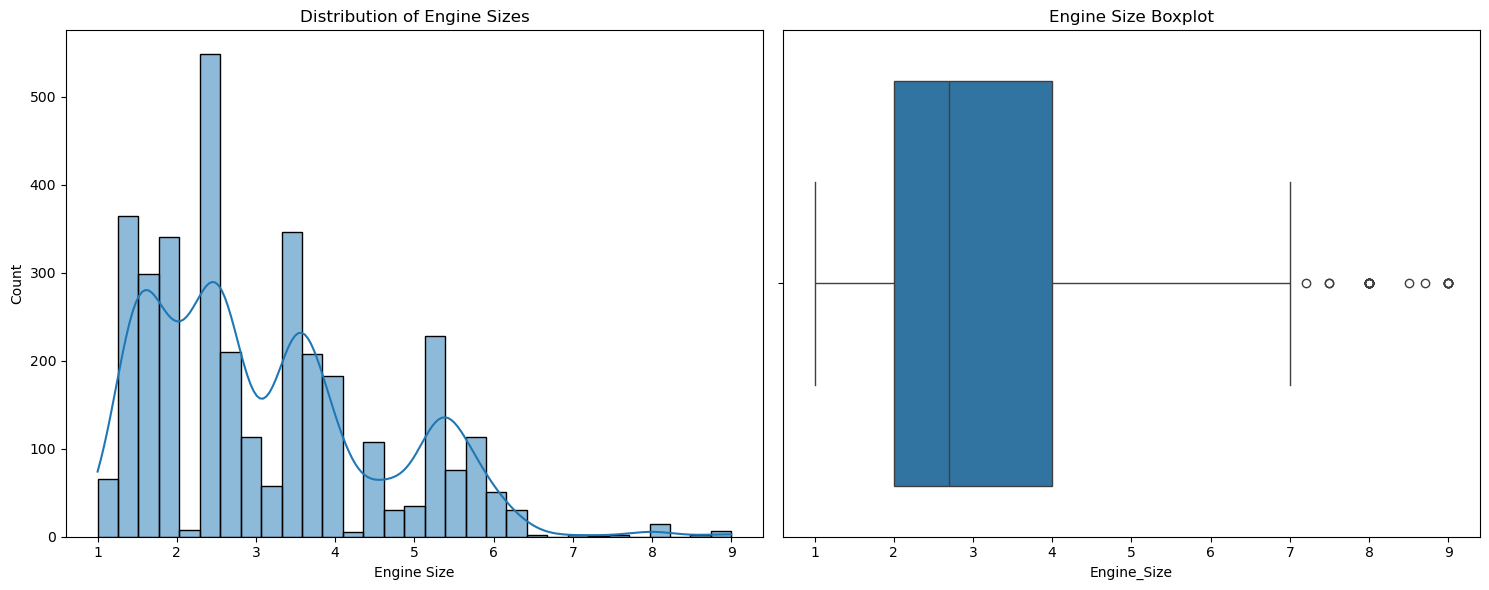

In [36]:
plt.figure(figsize=(15, 6))

# Engine Size distribution
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Engine_Size', kde = True, label = 'Distribution')
plt.title('Distribution of Engine Sizes')
plt.xlabel('Engine Size')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Engine_Size')
plt.title('Engine Size Boxplot')
plt.tight_layout();

The engine size distribution revealed natural groupings without requiring specific outlier removal because:

- The data showed expected clusters around common engine displacements (1.6L, 2.0L, 2.4L, etc.)
- Both histogram and boxplot visualizations showed no concerning outliers

#### **2. 3. 6. Categorical Features Analysis**

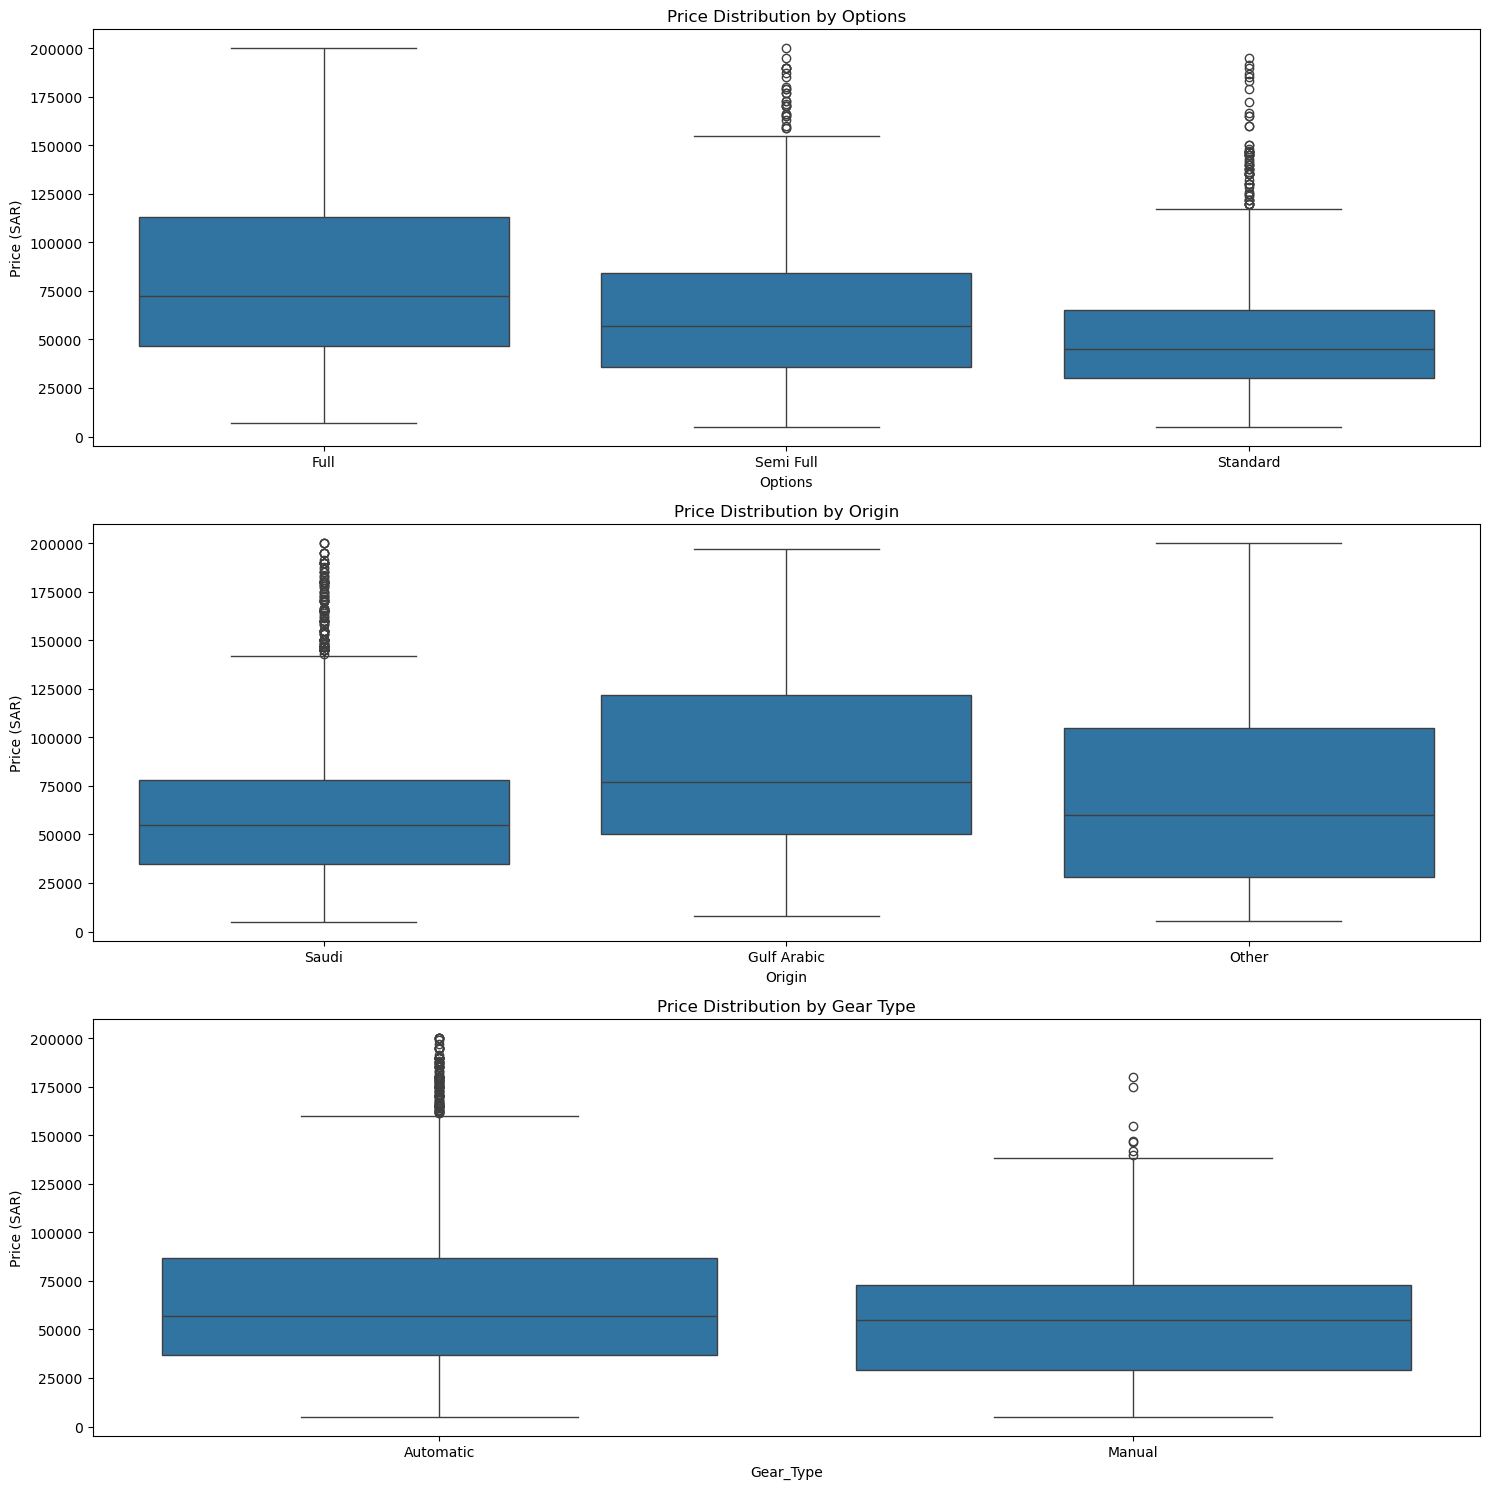

In [37]:
plt.figure(figsize=(15, 15))

# Options analysis
plt.subplot(3, 1, 1)
sns.boxplot(data=df, x='Options', y='Price')
plt.title('Price Distribution by Options')
plt.ylabel('Price (SAR)')

# Origin analysis
plt.subplot(3, 1, 2)
sns.boxplot(data=df, x='Origin', y='Price')
plt.title('Price Distribution by Origin')
plt.ylabel('Price (SAR)')

# Gear Type analysis
plt.subplot(3, 1, 3)
sns.boxplot(data=df, x='Gear_Type', y='Price')
plt.title('Price Distribution by Gear Type')
plt.ylabel('Price (SAR)')
plt.tight_layout();

We examined these features through boxplots of their relationship with price:

1. Options (Standard, Semi Full, Full):

Showed clear price differentiation between option levels

2. Origin:

Demonstrated distinct price patterns based on manufacturing country

3. Gear_Type:

Showed price variations between automatic and manual transmissions

#### **2. 3. 7. Region Analysis**

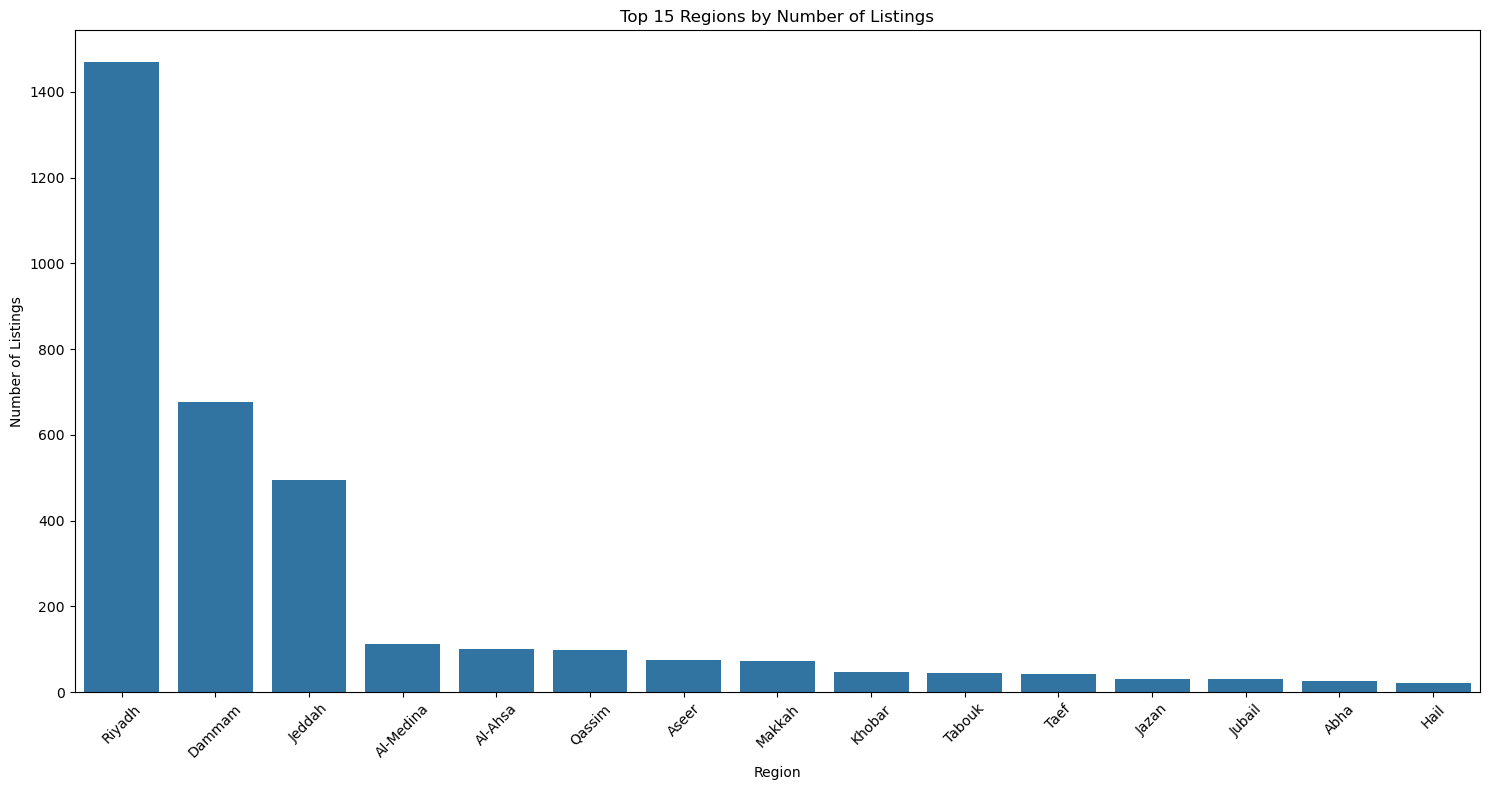

In [38]:
plt.figure(figsize = (15, 8))
top_regions = df['Region'].value_counts().head(15)
sns.barplot(x = top_regions.index,
            y = top_regions.values)
plt.title('Top 15 Regions by Number of Listings')
plt.xticks(rotation = 45)
plt.ylabel('Number of Listings')
plt.tight_layout();

We implemented geographical grouping to create more meaningful regional categories:

- Original data had 26 different cities
- Grouped into 5 main regions (Central, Eastern, Western, Southern, Northern) plus "Other Regions"

##### **Grouping 'Region' value from City into Region**

In [39]:
region_counts = df['Region'].value_counts()
print(f'Original Regions Distribution: {region_counts}')

Original Regions Distribution: Region
Riyadh            1470
Dammam             676
Jeddah             495
Al-Medina          113
Al-Ahsa            101
Qassim              98
Aseer               76
Makkah              73
Khobar              47
Tabouk              44
Taef                43
Jazan               31
Jubail              30
Abha                27
Hail                22
Al-Baha             17
Hafar Al-Batin      14
Yanbu               13
Najran              13
Al-Jouf             11
Al-Namas             9
Wadi Dawasir         5
Arar                 5
Qurayyat             4
Sakaka               4
Besha                3
Sabya                1
Name: count, dtype: int64


In [40]:
geographical_mapping = {
    # Central Region (Riyadh Region)
    'Riyadh': 'Central',
    'Qassim': 'Central',

    # Eastern Region
    'Dammam': 'Eastern',
    'Khobar': 'Eastern',
    'Al-Ahsa': 'Eastern',
    'Hafar Al-Batin': 'Eastern',
    'Jubail': 'Eastern',
    
    # Western Region (Makkah and Madinah Regions)
    'Jeddah': 'Western',
    'Makkah': 'Western',
    'Al-Medina': 'Western',
    'Yanbu': 'Western',
    'Taef': 'Western',
    
    # Southern Region
    'Abha': 'Southern',
    'Jazan': 'Southern',
    'Aseer': 'Southern',
    'Al-Baha': 'Southern',
    'Al-Namas': 'Southern',
    'Sabya': 'Southern',
    'Najran': 'Southern',
    'Besha': 'Southern',
    'Wadi Dawasir': 'Southern',
    
    # Northern Region
    'Hail': 'Northern',
    'Tabuk': 'Northern',
    'Al-Jouf': 'Northern',
    'Arar': 'Northern',
    'Qurayyat': 'Northern',
    'Sakaka': 'Northern'
}

df.insert(1, 'Region_Grouped', df['Region'].map(geographical_mapping))
df['Region_Grouped'] = df['Region_Grouped'].fillna('Other Regions')

print('Distribution of grouped regions: ')
print(df['Region_Grouped'].value_counts())

Distribution of grouped regions: 
Region_Grouped
Central          1568
Eastern           868
Western           737
Southern          182
Northern           46
Other Regions      44
Name: count, dtype: int64


##### **Updated dataset from 'Region' into 'Region_Grouped'**

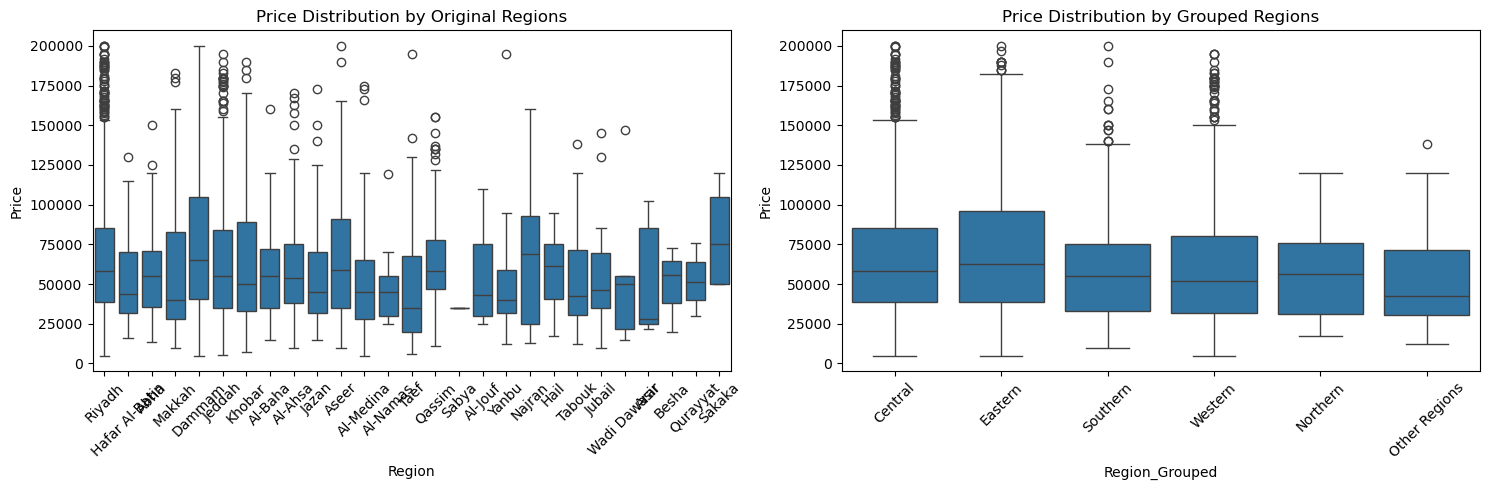

In [41]:
# Plot before and after distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Original regions
sns.boxplot(data=df, x='Region', y='Price', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_title('Price Distribution by Original Regions')

# Grouped regions
sns.boxplot(data=df, x='Region_Grouped', y='Price', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.set_title('Price Distribution by Grouped Regions')

plt.tight_layout();

#### **2. 3. 8. Correlation Matrix**

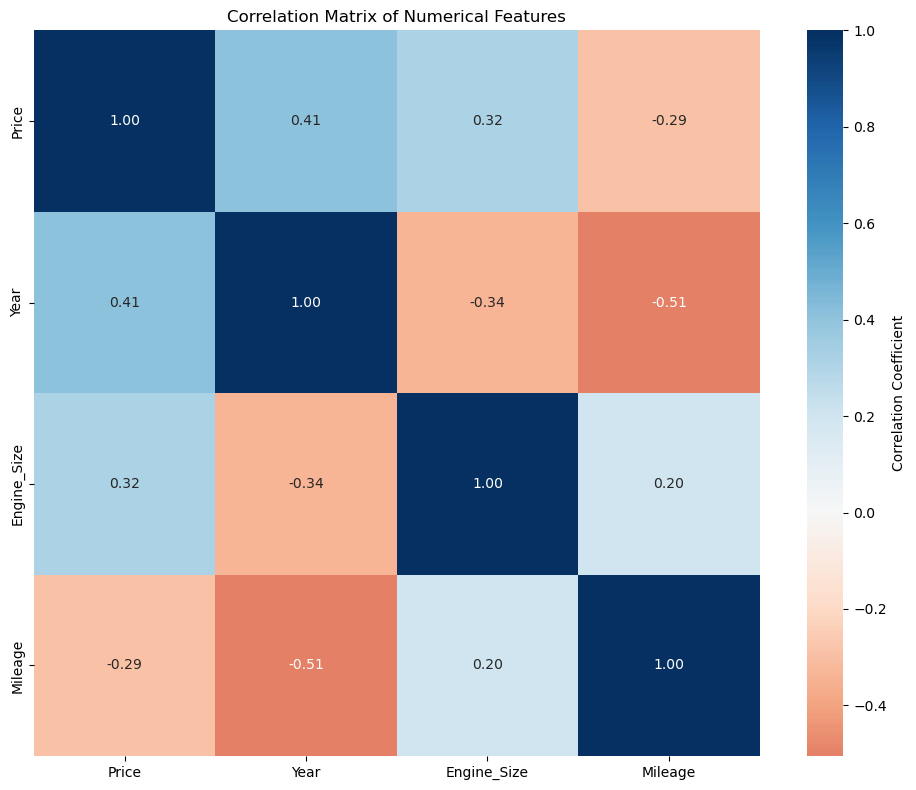

In [42]:
plt.figure(figsize=(10, 8))
numerical_features = ['Price', 'Year', 'Engine_Size', 'Mileage']
correlation_matrix = df[numerical_features].corr()

sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdBu', 
            center=0,
            fmt='.2f',
            square=True,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout();

The correlation analysis revealed important relationships between numerical features:

- Year showed positive correlation with price (0.53). Newer cars command higher prices

- Engine_Size showed moderate positive correlation with price (0.38). Larger engines generally indicate higher-end vehicles

- Mileage showed negative correlation with price (-0.41). Higher mileage typically reduces vehicle value

## **3. Preprocessing**

In [43]:
df_car = df.copy()

#### **3. 1. Drop Columns**

In [44]:
df_car.head()

,Type,Region_Grouped,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
1,Yukon,Central,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
3,Optima,Eastern,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
5,CX3,Southern,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,False,58000
6,Cayenne S,Central,Riyadh,Others,Automatic,Saudi,Full,2012,4.8,189000,False,85000
7,Sonata,Central,Riyadh,Hyundai,Automatic,Saudi,Full,2016,2.4,155,False,48000


Our preprocessing began with a look at our columns. One of our first decisions was to drop the 'Negotiable' column. Why? Well, this column wasn't telling us much - it was essentially a flag that would light up whenever the price was zero, which we'd already handled in our earlier cleaning steps.

We also bid farewell to the original 'Region' column. Remember how we created that nice 'Region_Grouped' column earlier? That was our upgraded version, consolidating cities into meaningful geographical regions that better reflected Saudi Arabia's market dynamics.

In [45]:
df_car.drop(['Negotiable'], axis = 1, inplace = True)
df_car.drop(['Region'], axis = 1, inplace = True)

#### **3. 2. Hypothesis Testing**

Then came one of our most interesting parts - hypothesis testing. We wanted to understand if different regions and origins truly influenced car prices or if these differences were just random noise.

##### **3. 2. 1. Hypothesis testing on the 'Region_Grouped'**

For the regions, we ran a Kruskal-Wallis test. Why Kruskal-Wallis? Well, our price data doesn't have a normal distribution assumptions, and this test doesn't care about that - it's like a more easy-going version of ANOVA.

In [46]:
from scipy import stats
from scipy.stats import kruskal

In [47]:
df_car['Region_Grouped'].value_counts()

Region_Grouped
Central          1568
Eastern           868
Western           737
Southern          182
Northern           46
Other Regions      44
Name: count, dtype: int64

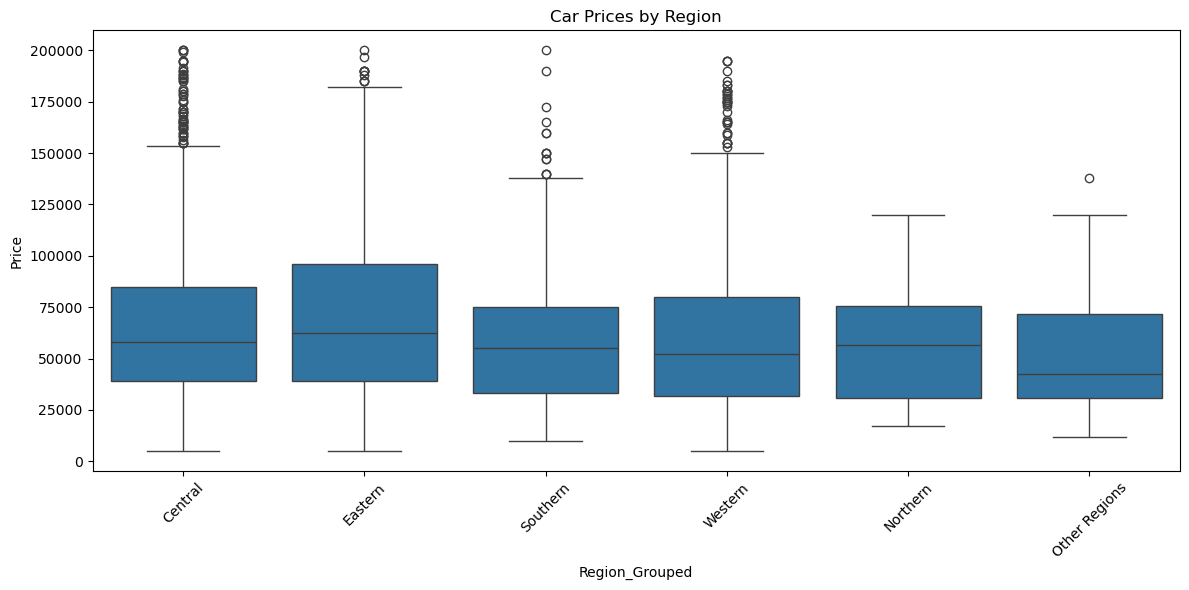

In [48]:
# First, let's create visualization to see the distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_car, x='Region_Grouped', y='Price')
plt.title('Car Prices by Region')
plt.xticks(rotation=45)
plt.tight_layout();

In [49]:
# Perform Kruskal-Wallis H-test
# H0: The distribution of prices is the same across all regions
# Ha: The distribution of prices is not the same across all regions

regions = df_car['Region_Grouped'].unique()
prices_by_region = [df_car[df_car['Region_Grouped'] == region]['Price'] for region in regions]

# Perform Kruskal-Wallis H-test
h_statistic, p_value = stats.kruskal(*prices_by_region)

print("\nKruskal-Wallis H-test Results:")
print(f"H-statistic: {h_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpret results
alpha = 0.05
print("\nHypothesis Test Results:")
if p_value < alpha:
    print(f"Reject H0 (p-value < {alpha})")
    print("There is significant evidence that the distribution of car prices differs across regions")
else:
    print(f"Fail to reject H0 (p-value >= {alpha})")
    print("There is not enough evidence to conclude that the distribution of car prices differs across regions")


Kruskal-Wallis H-test Results:
H-statistic: 42.7826
p-value: 0.0000

Hypothesis Test Results:
Reject H0 (p-value < 0.05)
There is significant evidence that the distribution of car prices differs across regions


With a p-value way below our 0.05 threshold, we discovered that yes, where a car is sold in Saudi Arabia does matter for its price. This wasn't just random variation - different regions had genuinely different pricing patterns.

##### **3. 2. 2. Hypothesis testing on the 'Origin'**

In [50]:
df_car['Origin'].value_counts()

Origin
Saudi          2650
Gulf Arabic     421
Other           374
Name: count, dtype: int64

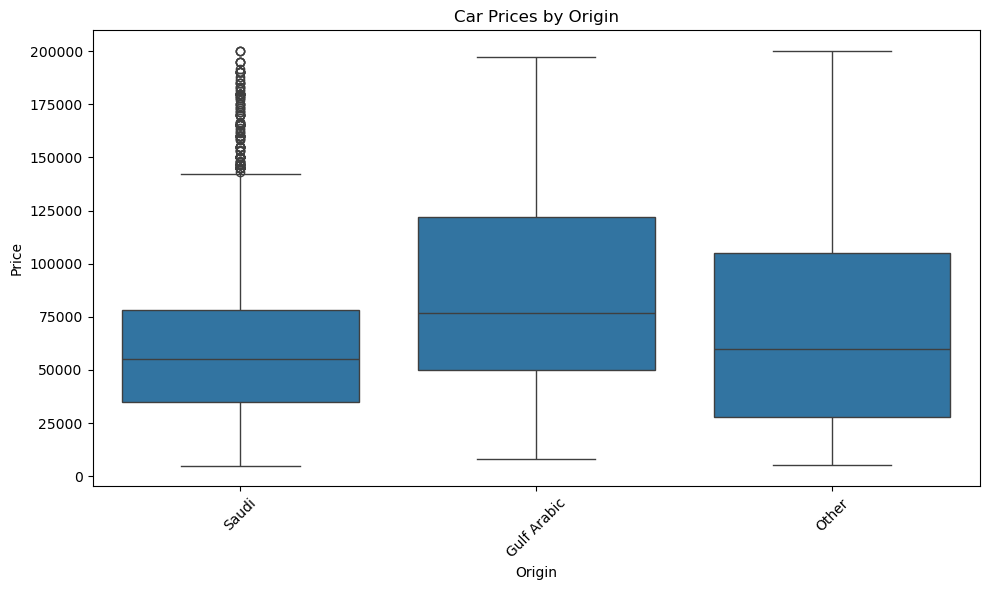

In [51]:
plt.figure(figsize = (10, 6))
sns.boxplot(data = df_car, x = 'Origin', y = 'Price')
plt.title('Car Prices by Origin')
plt.xticks(rotation = 45)
plt.tight_layout();

In [52]:
# Perform Kruskal-Wallis H-test
# H0: The distribution of prices is the same across all regions
# Ha: The distribution of prices is not the same across all regions

regions = df_car['Origin'].unique()
prices_by_origin = [df_car[df_car['Origin'] == region]['Price'] for region in regions]

# Perform Kruskal-Wallis H-test
h_statistic, p_value = stats.kruskal(*prices_by_origin)

print("\nKruskal-Wallis H-test Results:")
print(f"H-statistic: {h_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpret results
alpha = 0.05
print("\nHypothesis Test Results:")
if p_value < alpha:
    print(f"Reject H0 (p-value < {alpha})")
    print("There is significant evidence that the distribution of car prices differs across regions")
else:
    print(f"Fail to reject H0 (p-value >= {alpha})")
    print("There is not enough evidence to conclude that the distribution of car prices differs across regions")


Kruskal-Wallis H-test Results:
H-statistic: 116.7840
p-value: 0.0000

Hypothesis Test Results:
Reject H0 (p-value < 0.05)
There is significant evidence that the distribution of car prices differs across regions


The same story played out when we tested car origins. The price differences between cars from different manufacturing countries were statistically significant.

After this statistical exploration, we reset our index

##### **Drop Columns 'index'**

In [53]:
df_car = df_car.reset_index().drop(columns = ['index'])
df_car

,Type,Region_Grouped,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Price
0,Yukon,Central,GMC,Automatic,Saudi,Full,2014,8.0,80000,120000
1,Optima,Eastern,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,42000
2,CX3,Southern,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,58000
3,Cayenne S,Central,Others,Automatic,Saudi,Full,2012,4.8,189000,85000
4,Sonata,Central,Hyundai,Automatic,Saudi,Full,2016,2.4,155,48000
...,...,...,...,...,...,...,...,...,...,...
3440,CX9,Central,Mazda,Automatic,Saudi,Full,2020,2.0,9500,132000
3441,Suburban,Central,GMC,Automatic,Saudi,Full,2006,5.3,86000,50000
3442,X-Trail,Western,Nissan,Automatic,Saudi,Standard,2018,2.5,78794,68000
3443,Yukon,Eastern,GMC,Automatic,Saudi,Full,2016,5.3,48000,145000


In [54]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3445 entries, 0 to 3444
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Type            3445 non-null   object 
 1   Region_Grouped  3445 non-null   object 
 2   Make            3445 non-null   object 
 3   Gear_Type       3445 non-null   object 
 4   Origin          3445 non-null   object 
 5   Options         3445 non-null   object 
 6   Year            3445 non-null   int64  
 7   Engine_Size     3445 non-null   float64
 8   Mileage         3445 non-null   int64  
 9   Price           3445 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 269.3+ KB


In [55]:
# Check deskriptif statistics
num_features = [feature for feature in df_car.columns if ((df_car[feature].dtypes != 'object'))]
df_car[num_features].describe()

,Year,Engine_Size,Mileage,Price
count,3445.000000,3445.000000,3445.000000,3445.000000
mean,2015.092888,3.113149,131092.655152,66548.973295
std,3.899815,1.436192,105466.690387,40743.927044
min,2000.000000,1.000000,100.000000,5000.000000
25%,2013.000000,2.000000,55000.000000,36000.000000
50%,2016.000000,2.700000,108000.000000,57000.000000
75%,2018.000000,4.000000,188000.000000,85000.000000
max,2021.000000,9.000000,573000.000000,200000.000000


## **4. Modeling**

In [56]:
# Import library untuk modeling

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold

from category_encoders import BinaryEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import RobustScaler, OrdinalEncoder

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

### **4. 1. Encoding**

In [57]:
df_car

,Type,Region_Grouped,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Price
0,Yukon,Central,GMC,Automatic,Saudi,Full,2014,8.0,80000,120000
1,Optima,Eastern,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,42000
2,CX3,Southern,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,58000
3,Cayenne S,Central,Others,Automatic,Saudi,Full,2012,4.8,189000,85000
4,Sonata,Central,Hyundai,Automatic,Saudi,Full,2016,2.4,155,48000
...,...,...,...,...,...,...,...,...,...,...
3440,CX9,Central,Mazda,Automatic,Saudi,Full,2020,2.0,9500,132000
3441,Suburban,Central,GMC,Automatic,Saudi,Full,2006,5.3,86000,50000
3442,X-Trail,Western,Nissan,Automatic,Saudi,Standard,2018,2.5,78794,68000
3443,Yukon,Eastern,GMC,Automatic,Saudi,Full,2016,5.3,48000,145000


We developed a preprocessing pipeline that handles different types of features appropriately:

- Some of our features, like 'Region_Grouped', 'Origin', and 'Gear_Type', were categorical. For these, we used OneHotEncoder, which essentially creates separate "yes/no" columns for each category.
- For our 'Options' feature, which had a natural order (Standard < Semi Full < Full), we used OrdinalEncoder. This is like assigning numbers to cooking temperatures - there's a clear progression from low to high.
- The 'Type' and 'Make' features got special treatment with BinaryEncoder, which is particularly good at handling categories with many options without creating too many new columns.
- Our numerical features - 'Year', 'Engine_Size', and 'Mileage' - needed scaling. Using RobustScaler to makes sure all our numbers play well together without letting outliers throw off the measurements.

In [58]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(), ['Region_Grouped', 'Origin', 'Gear_Type']),
    ('ordinal', OrdinalEncoder(categories = [['Standard', 'Semi Full', 'Full']]), ['Options']),
    ('binary', BinaryEncoder(), ['Type', 'Make']),
    ('robust', RobustScaler(), ['Year', 'Engine_Size', 'Mileage'])
], remainder = 'passthrough')

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot', OneHotEncoder(),
                                 ['Region_Grouped', 'Origin', 'Gear_Type']),
                                ('ordinal',
                                 OrdinalEncoder(categories=[['Standard',
                                                             'Semi Full',
                                                             'Full']]),
                                 ['Options']),
                                ('binary', BinaryEncoder(), ['Type', 'Make']),
                                ('robust', RobustScaler(),
                                 ['Year', 'Engine_Size', 'Mileage'])])

### **4. 2. Data Splitting**

The 80-20 split is a time-tested approach that gives us enough data to train our models while keeping enough aside to verify their performance.

In [59]:
X = df_car.drop(columns = ['Price'])
y = df_car['Price']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 0)

### **4. 3. Benchmark Model**

In [60]:
from imblearn.pipeline import Pipeline

Our approach to modeling this problem evolved through several stages. We began by evaluating five different algorithms, each chosen for its specific strengths in handling valuations:

1. Linear Regression served as our baseline, testing if simple linear relationships could adequately explain price variations. This also provided a benchmark for how much complexity we actually needed to add.
2. K-Nearest Neighbors was included because it mirrors how humans often value cars - by comparing them to similar vehicles. This approach could be particularly useful for unique or rare models where direct comparisons are more reliable than general rules.
3. Decision Trees appealed because their decision-making process is transparent and mirrors how humans think about car values ("If it's a luxury brand AND less than 5 years old, THEN it's worth more"). This transparency could help Syarah explain price recommendations to users.
4. Random Forest and XGBoost were our advanced options, capable of capturing complex interactions between features. For example, how the impact of mileage on price might vary depending on the brand's reputation for reliability.

In [61]:
# Define all models
models = {
    'LinearRegression': TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp),
    'KNeighbors': TransformedTargetRegressor(KNeighborsRegressor(), func=np.log, inverse_func=np.exp),
    'DecisionTree': TransformedTargetRegressor(DecisionTreeRegressor(random_state=0), func=np.log, inverse_func=np.exp),
    'RandomForest': TransformedTargetRegressor(RandomForestRegressor(random_state=0), func=np.log, inverse_func=np.exp),
    'XGBoost': TransformedTargetRegressor(XGBRegressor(random_state=0), func=np.log, inverse_func=np.exp),
}

crossval = KFold(n_splits=5, shuffle=True, random_state = 0)

results = []

# Looking for the best algorithm based on each metric
for name, model in models.items():
    
    estimator = Pipeline([
        ('preprocessing', transformer),
        ('model', model)
    ])

    # Calculate MAPE
    mape_scores = -cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv=crossval, 
        scoring='neg_mean_absolute_percentage_error'
        )
    
    # Calculate RMSE
    rmse_scores = np.sqrt(-cross_val_score(
        estimator,
        X_train,
        y_train,
        cv=crossval,
        scoring='neg_mean_squared_error'
    ))

    results.append({
        'Model': name,
        'Mean_MAPE': mape_scores.mean(),
        'Std_MAPE': mape_scores.std(),
        'Mean_RMSE': rmse_scores.mean(),
        'Std_RMSE': rmse_scores.std(),
    })

print('Benchmark Results: ')
pd.DataFrame(results)

Benchmark Results: 


,Model,Mean_MAPE,Std_MAPE,Mean_RMSE,Std_RMSE
0,LinearRegression,0.313529,0.012499,27611.680171,2280.669232
1,KNeighbors,0.302625,0.021836,23295.548397,1655.289360
2,DecisionTree,0.348506,0.063435,28947.236331,1983.864285
3,RandomForest,0.215828,0.015875,20004.361412,2011.171836
4,XGBoost,0.205027,0.010527,18146.123629,1424.009699


We applied a logarithmic transformation to our price predictions, reflecting how car values tend to depreciate exponentially rather than linearly. This matches real-world pricing patterns where newer cars depreciate faster than older ones. For Syarah's users, this means more accurate predictions across different price ranges.

The cross-validation results highlighted XGBoost and Random Forest as our strongest performers. This wasn't surprising since both models excel at capturing the complex relationships in features. 

### **4. 4. Test for Best Models**

In [62]:
best_models = {
    'XGBRegressor': XGBRegressor(random_state=0),
    'RandomForest': RandomForestRegressor(random_state=0)
}

score_mape = []
score_rmse = []

for name, model in best_models.items():

    model = Pipeline([
        ('preprocessing', transformer),
        ('model', model)
        ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score_mape.append(mean_absolute_percentage_error(y_test, y_pred))
    score_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))  

score_before_tuning = pd.DataFrame({
    'MAPE': score_mape,
    'RMSE': score_rmse
    }, index = best_models.keys())

print('Best Models Performance Before Tuning: ')
score_before_tuning

Best Models Performance Before Tuning: 


,MAPE,RMSE
XGBRegressor,0.205745,17322.149520
RandomForest,0.206435,18142.774626


XGBoost will be our model, and before we go to Tuning, let me explain how XGBoost works. 

XGBoost (eXtreme Gradient Boosting) approaches price prediction through an ensemble learning method that builds a sequence of decision trees, each focused on correcting the mistakes of previous trees. The process starts with a baseline prediction, like the average car price, and iteratively refines it by analyzing and learning from prediction errors.

What sets XGBoost apart is its use of second-order derivatives in the learning process. While traditional gradient boosting only looks at how wrong a prediction was, XGBoost considers both the error magnitude and the confidence level needed for corrections. This sophisticated approach is particularly valuable for car pricing, where some price relationships (like year-to-value) are more reliable than others (like color-to-value).

The algorithm employs several safeguards against overfitting. Through parameters like 'max_depth' and regularization terms (L1 and L2), it ensures the model learns genuine pricing patterns rather than memorizing specific examples.

### **4. 5. Hyperparameter Tuning**

After identifying XGBoost as our most promising model, we embarked on a careful tuning process. Each parameter we adjusted had specific business implications:

- max_depth (3-20): determined how complex our pricing rules could become. Too shallow, and we might miss important feature interactions that drive value. Too deep, and we might start capturing noise in the data that doesn't reflect real market patterns.
- learning_rate (0.01-0.3): This parameter, also called 'eta', is like setting the model's confidence in each adjustment it makes. At 0.01, it's very cautious - making tiny adjustments with each tree. At 0.3, it makes bolder changes.
- n_estimators (100-500): Determines how many trees we build. More trees generally mean better predictions, but there's a point of diminishing returns.
- subsample (0.6-1.0): This controls what portion of our training data each tree gets to see. A value of 0.6 means each tree only sees 60% of the data, randomly selected. 
- min_child_weight (1-7): Higher values (like 7) make it harder to create splits, which can help prevent overfitting but might miss real patterns. Lower values (like 1) allow more detailed patterns to be learned.
- gamma (0-0.5): Gamma is the minimum loss reduction needed to make a split. It's like setting a threshold for how much better a split needs to make our predictions to be worth it.
- colsample_bytree (0.6-1.0): Similar to subsample, but this works on features rather than rows. 
- reg_alpha (range: 0-10.0): This is our L1 regularization term. We start at 0 (no penalty) and go up to 10.0, which would create significant pressure for simplification. This helps prevent the model from relying too heavily on any single feature.

In [63]:
param_grid = {
    'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    'model__learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3],
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'model__min_child_weight': [1, 3, 5, 7],
    'model__gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'model__reg_alpha': [0, 0.1, 0.5, 1.0, 10.0]
}

# Benchmark model dengan hyperparameter tuning
xgb = XGBRegressor(random_state=0, 
                   verbosity=0)

# Membuat algorithm chains
estimator_xgb = Pipeline([
        ('preprocessing', transformer),
        ('model', xgb)
        ])

# Hyperparameter tuning
random_xgb = RandomizedSearchCV(
    estimator_xgb, 
    param_distributions = param_grid,
    n_iter = 100,
    cv = crossval, 
    scoring = ['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
    n_jobs = -1,
    refit = 'neg_mean_absolute_error', 
    random_state = 0  
)

We used RandomizedSearchCV with 100 iterations to efficiently explore this vast space of possibilities. Rather than trying every possible combination (which would take too long).

In [64]:
random_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(),
                                                                               ['Region_Grouped',
                                                                                'Origin',
                                                                                'Gear_Type']),
                                                                              ('ordinal',
                                                                               OrdinalEncoder(categories=[['Standard',
                                                                                                           'Semi '
                                                                                                           'Full',
                                                                                                           'Full']]),
                                                                               ['Options']),
                                                                              ('binary',
                                                                               BinaryEncoder(),
                                                                               ['Ty...
                                        'model__learning_rate': [0.01, 0.03,
                                                                 0.05, 0.07,
                                                                 0.1, 0.2,
                                                                 0.3],
                                        'model__max_depth': [3, 4, 5, 6, 7, 8,
                                                             9, 10, 15, 20],
                                        'model__min_child_weight': [1, 3, 5, 7],
                                        'model__n_estimators': [100, 200, 300,
                                                                400, 500],
                                        'model__reg_alpha': [0, 0.1, 0.5, 1.0,
                                                             10.0],
                                        'model__subsample': [0.6, 0.7, 0.8, 0.9,
                                                             1.0]},
                   random_state=0, refit='neg_mean_absolute_error',
                   scoring=['neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error'])

In [65]:
random_xgb.best_params_

{'model__subsample': 0.6,
 'model__reg_alpha': 10.0,
 'model__n_estimators': 500,
 'model__min_child_weight': 3,
 'model__max_depth': 6,
 'model__learning_rate': 0.05,
 'model__gamma': 0.5,
 'model__colsample_bytree': 0.8}

### **4. 6. Model Evaluation**

After tuning, we needed to understand exactly how well our model was performing. We looked at our predictions from multiple angles:
The residual analysis tells a detailed story:

- The residuals vs. predicted values plot helped us spot if our model was consistently over or under-predicting certain price ranges
- The residual distribution showed us how our errors were spread out

In [66]:
XGBRegressor_tuned = random_xgb.best_estimator_
y_pred_tuned = XGBRegressor_tuned.predict(X_test)

final_mape = mean_absolute_percentage_error(y_test, y_pred_tuned)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

score_after_tuning = pd.DataFrame({
    'MAPE': [final_mape],
    'RMSE': [final_rmse]
    }, index = ['XGBRegressor_tuned'])

print("\nScore before Tuning: ")
display(pd.DataFrame(score_before_tuning.loc['XGBRegressor']).T)

print("\nFinal Score after Tuning: ")
display(score_after_tuning)


Score before Tuning: 


,MAPE,RMSE
XGBRegressor,0.205745,17322.14952



Final Score after Tuning: 


,MAPE,RMSE
XGBRegressor_tuned,0.180311,15910.914996


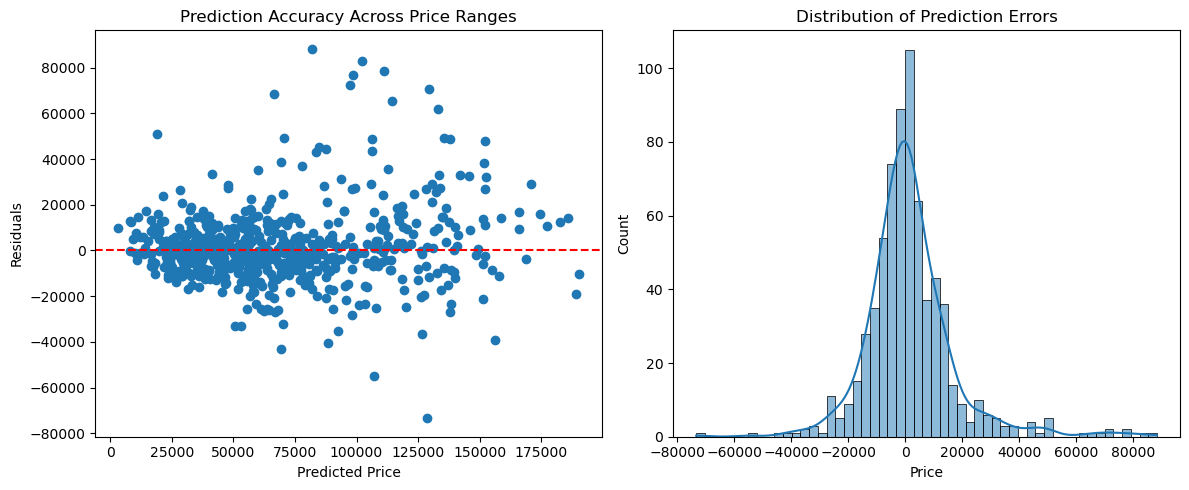

In [67]:
# Calculate residuals
residuals = y_test - y_pred_tuned

# Create focused residual analysis plots
plt.figure(figsize=(12, 5))

# Residuals vs Predicted Values
plt.subplot(1, 2, 1)
plt.scatter(y_pred_tuned, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Prediction Accuracy Across Price Ranges')

# Residual Distribution
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Distribution of Prediction Errors')

plt.tight_layout();

The residual analysis revealed that our model performs consistently across different price ranges. This is crucial for Syarah as it means the system is equally reliable whether someone is selling an economy car or a luxury vehicle. The normally distributed errors suggest our predictions aren't systematically biased towards either buyers or sellers.

### **4. 7. Feature Importance Analysis**

#### **4. 7. 1. SHAP (SHapley Additive exPlanations) Analysis**

This sophisticated technique showed us how each feature contributes to individual predictions. 

In [68]:
import shap

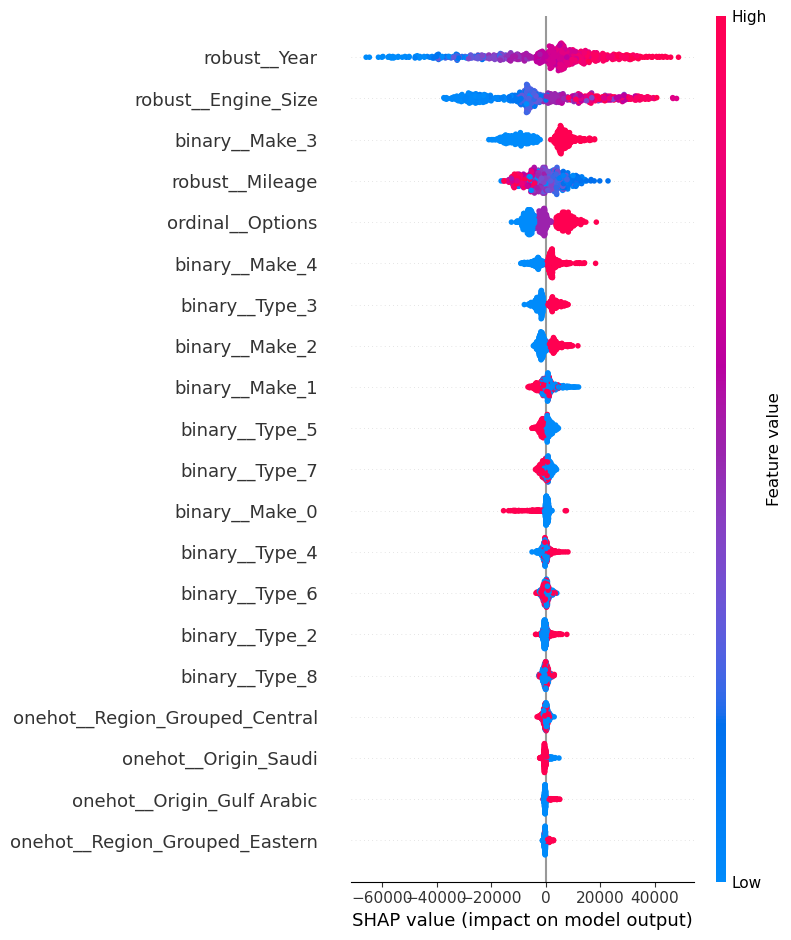

In [69]:
transformed_features = XGBRegressor_tuned.named_steps['preprocessing'].get_feature_names_out()

explainer = shap.TreeExplainer(XGBRegressor_tuned.named_steps['model'])

X_test_transformed = XGBRegressor_tuned.named_steps['preprocessing'].transform(X_test)

shap_values = explainer.shap_values(X_test_transformed)

feature_names = transformed_features

plt.figure(figsize=(15, 10))
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

- The year of manufacture consistently emerged as a strong price indicator
- Mileage had a significant but non-linear impact on prices
- Certain makes and types had outsized influences on specific price ranges

#### **4.7.2. XGBoost Feature Importance**

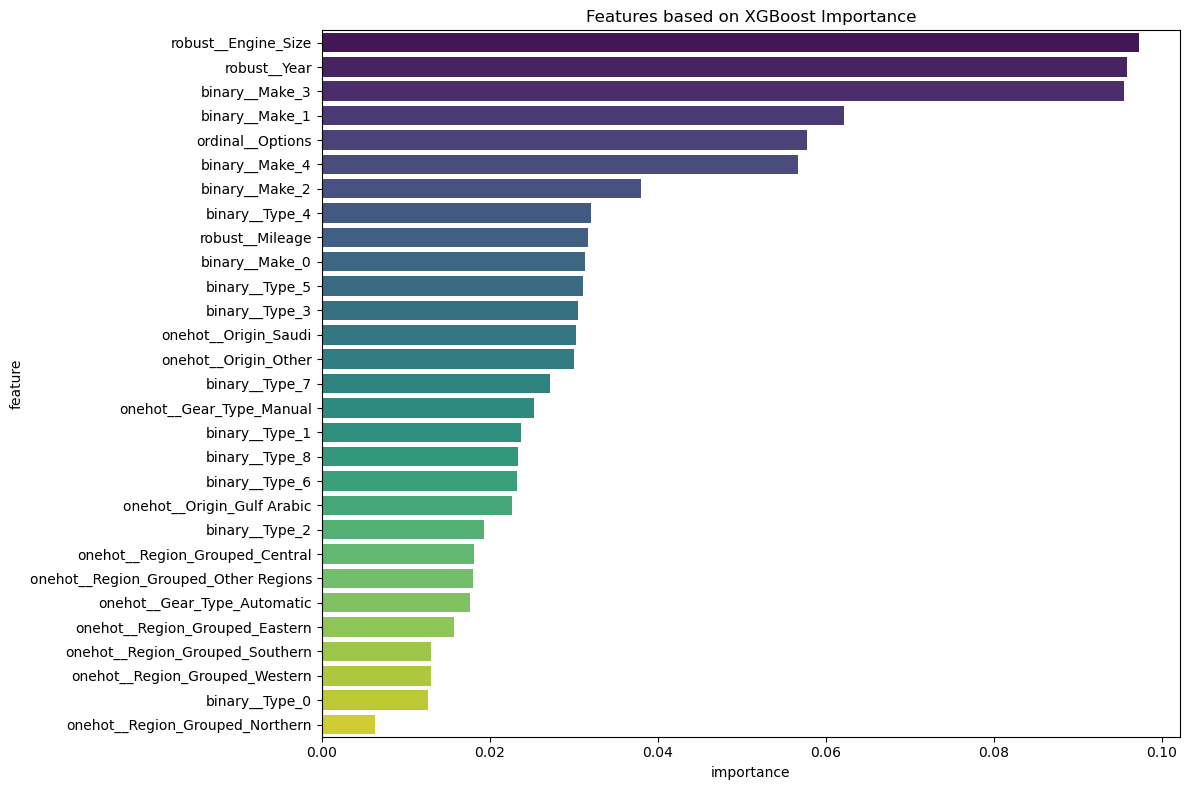

In [70]:
# Get feature importance from XGBoost model
feature_importance = pd.DataFrame({
    'feature': transformed_features,
    'importance': XGBRegressor_tuned.named_steps['model'].feature_importances_
}).sort_values('importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance, 
            x='importance', 
            y='feature',
            palette = 'viridis')
plt.title('Features based on XGBoost Importance')
plt.tight_layout();

This gave us a more global view of feature importance, showing which features were most frequently used to make splits in our decision trees. The visualization helped us see that:

- Some features we thought might be important turned out to have less impact than expected
- Others surprised us with their strong influence on prices

After our initial modeling phase, one of the most enlightening insights came from our feature importance analysis. Both SHAP values and XGBoost's built-in importance metrics showed us something intriguing: despite our  preprocessing and hypothesis testing of 'Region_Grouped' and 'Origin', these features weren't contributing as much to price predictions as we initially thought.

Remember earlier when we ran those Kruskal-Wallis tests? They told us there were statistically significant differences in prices across regions and origins. However, statistical significance doesn't always translate to practical importance in machine learning. It's like finding out that while the color of a car might technically affect its price, the effect is so small compared to factors like mileage or year.

This led us to make a data-driven decision: removing these columns for our remodeling phase. 

The reasoning was:

1. By removing features that weren't pulling their weight, we could create a more efficient model. 

2. Each feature we include adds complexity to our model. If a feature isn't contributing meaningfully to predictions, it's just adding noise. 

3. Our feature importance analysis showed that factors like year, mileage, and make were the real heavy lifters in predicting prices. By removing less important features, we're letting our model focus more on these crucial factors.

## **5. Remodeling**

### **5. 1. Drop features**

Having learned from our feature importance analysis that 'Region_Grouped' and 'Origin' weren't crucial predictors, we began by dropping these columns. 

In [71]:
df_car = df_car.drop(['Region_Grouped', 'Origin'], axis=1)

### **5. 2. Encoding**

Our revised preprocessing pipeline reflected this more focused approach:


In [72]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(), ['Gear_Type']),
    ('ordinal', OrdinalEncoder(categories=[['Standard', 'Semi Full', 'Full']]), ['Options']),
    ('binary', BinaryEncoder(), ['Type', 'Make']),
    ('robust', RobustScaler(), ['Year', 'Engine_Size', 'Mileage'])
], remainder='passthrough')

This transformation process maintained our handling of different feature types while removing unnecessary complexity. 

### **5. 3. Data Splitting**

In [73]:
X = df_car.drop(columns=['Price'])
y = df_car['Price']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

### **5. 4. Benchmark Model**

In [74]:
models = {
    'LinearRegression': TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp),
    'KNeighbors': TransformedTargetRegressor(KNeighborsRegressor(), func=np.log, inverse_func=np.exp),
    'DecisionTree': TransformedTargetRegressor(DecisionTreeRegressor(random_state=0), func=np.log, inverse_func=np.exp),
    'RandomForest': TransformedTargetRegressor(RandomForestRegressor(random_state=0), func=np.log, inverse_func=np.exp),
    'XGBoost': TransformedTargetRegressor(XGBRegressor(random_state=0), func=np.log, inverse_func=np.exp),
}

results = []

for name, model in models.items():
    
    estimator = Pipeline([
        ('preprocessing', transformer),
        ('model', model)
    ])
    
    # Calculate metrics
    mape_scores = -cross_val_score(
        estimator, X_train, y_train,
        cv=crossval, scoring='neg_mean_absolute_percentage_error'
    )
    
    rmse_scores = np.sqrt(-cross_val_score(
        estimator, X_train, y_train,
        cv=crossval, scoring='neg_mean_squared_error'
    ))
    
    results.append({
        'Model': name,
        'Mean_MAPE': mape_scores.mean(),
        'Std_MAPE': mape_scores.std(),
        'Mean_RMSE': rmse_scores.mean(),
        'Std_RMSE': rmse_scores.std()
    })

print("Benchmark Results:")
pd.DataFrame(results)

Benchmark Results:


,Model,Mean_MAPE,Std_MAPE,Mean_RMSE,Std_RMSE
0,LinearRegression,0.315394,0.011129,28002.257697,2507.887002
1,KNeighbors,0.281665,0.016523,21226.948733,1810.382521
2,DecisionTree,0.313332,0.040797,27319.620137,1517.011671
3,RandomForest,0.212964,0.014663,19672.293072,1919.839383
4,XGBoost,0.206801,0.013614,18362.013676,1284.140560


All our models, from Linear Regression to XGBoost, showed either maintained or improved performance. This validated our feature selection decisions – by removing noise from our data, we enabled each model to focus on the most meaningful price relationships. The improved performance was particularly noticeable in the consistency of predictions across different price ranges.

### **5. 5. Test for Best Models**

In [75]:
best_models = {
    'XGBRegressor': XGBRegressor(random_state=0),
    'RandomForest': RandomForestRegressor(random_state=0)
}

score_mape = []
score_rmse = []

for name, model in best_models.items():
    remodeling = Pipeline([
        ('preprocessing', transformer),
        ('model', model)
    ])
    
    remodeling.fit(X_train, y_train)
    y_pred = remodeling.predict(X_test)
    
    score_mape.append(mean_absolute_percentage_error(y_test, y_pred))
    score_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))

score_before_tuning = pd.DataFrame({
    'MAPE': score_mape,
    'RMSE': score_rmse
}, index=best_models.keys())

print("Best Models Performance Before Tuning:")
pd.DataFrame(score_before_tuning)

Best Models Performance Before Tuning:


,MAPE,RMSE
XGBRegressor,0.197611,16601.637510
RandomForest,0.203206,17939.315969


The best performing models were still XGBoost and Random Forest. Without the noise from regional and origin data, they could focus more effectively on the strong predictive features. We move forward with XGBoost model

### **5. 6. Hyperparameter Tuning**

In [76]:
estimator_xgb = Pipeline([
    ('preprocessing', transformer),
    ('model', XGBRegressor(random_state=0, verbosity=0))
])

random_xgb = RandomizedSearchCV(
    estimator_xgb,
    param_distributions=param_grid,
    n_iter=100,
    cv=crossval,
    scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'],
    n_jobs=-1,
    refit='neg_mean_absolute_error',
    random_state=0
)

random_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(),
                                                                               ['Gear_Type']),
                                                                              ('ordinal',
                                                                               OrdinalEncoder(categories=[['Standard',
                                                                                                           'Semi '
                                                                                                           'Full',
                                                                                                           'Full']]),
                                                                               ['Options']),
                                                                              ('binary',
                                                                               BinaryEncoder(),
                                                                               ['Type',
                                                                                'Make']),
                                                                              ('robust',
                                                                               Rob...
                                        'model__learning_rate': [0.01, 0.03,
                                                                 0.05, 0.07,
                                                                 0.1, 0.2,
                                                                 0.3],
                                        'model__max_depth': [3, 4, 5, 6, 7, 8,
                                                             9, 10, 15, 20],
                                        'model__min_child_weight': [1, 3, 5, 7],
                                        'model__n_estimators': [100, 200, 300,
                                                                400, 500],
                                        'model__reg_alpha': [0, 0.1, 0.5, 1.0,
                                                             10.0],
                                        'model__subsample': [0.6, 0.7, 0.8, 0.9,
                                                             1.0]},
                   random_state=0, refit='neg_mean_absolute_error',
                   scoring=['neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error'])

### **5. 7. Model Evaluation**

In [77]:
XGBRegressor_tuned = random_xgb.best_estimator_
y_pred_tuned = XGBRegressor_tuned.predict(X_test)

final_mape = mean_absolute_percentage_error(y_test, y_pred_tuned)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

score_after_tuning = pd.DataFrame({
    'MAPE': [final_mape],
    'RMSE': [final_rmse]
}, index=['XGBRegressor_tuned'])

print("\nScore before Tuning: ")
display(pd.DataFrame(score_before_tuning.loc['XGBRegressor']).T)

print("\nFinal Results after Tuning:")
pd.DataFrame(score_after_tuning)


Score before Tuning: 


,MAPE,RMSE
XGBRegressor,0.197611,16601.63751



Final Results after Tuning:


,MAPE,RMSE
XGBRegressor_tuned,0.175462,15452.372763


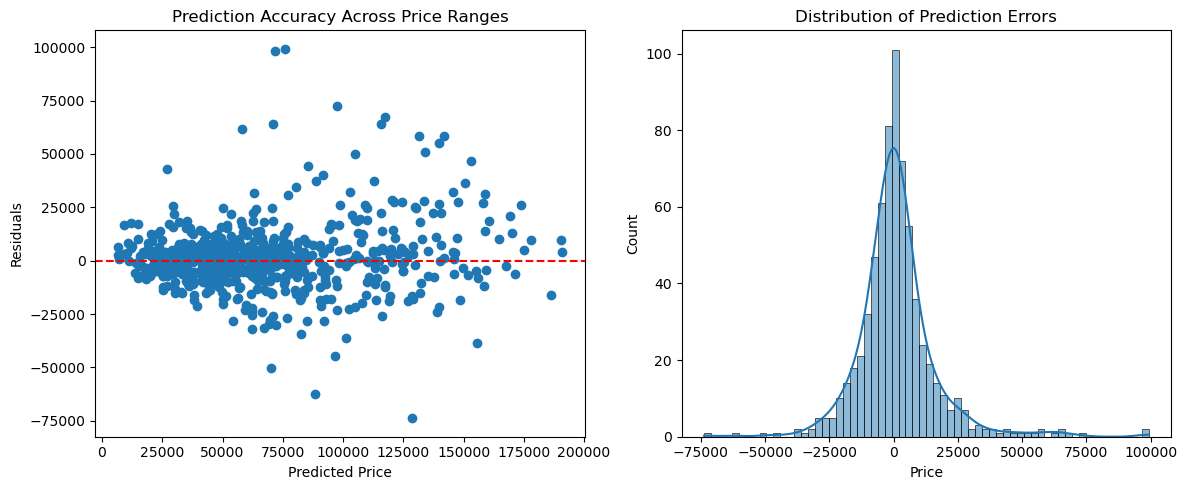

In [78]:
# Calculate residuals
residuals = y_test - y_pred_tuned

# Create focused residual analysis plots
plt.figure(figsize=(12, 5))

# Residuals vs Predicted Values
plt.subplot(1, 2, 1)
plt.scatter(y_pred_tuned, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Prediction Accuracy Across Price Ranges')

# Residual Distribution
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Distribution of Prediction Errors')

plt.tight_layout();

Our remodeled XGBoost implementation achieved several key improvements:

1. The model maintained its strong MAPE and RMSE performance while showing more consistent accuracy across different vehicle categories.
2. With fewer features to process, the model could generate price predictions more quickly – a crucial consideration for Syarah's real-time pricing needs.
3. Cleaner residual plots showing more normally distributed errors


### **5. 8. Feature Importance Analysis**

#### **5. 8. 1. Shap Modeling**

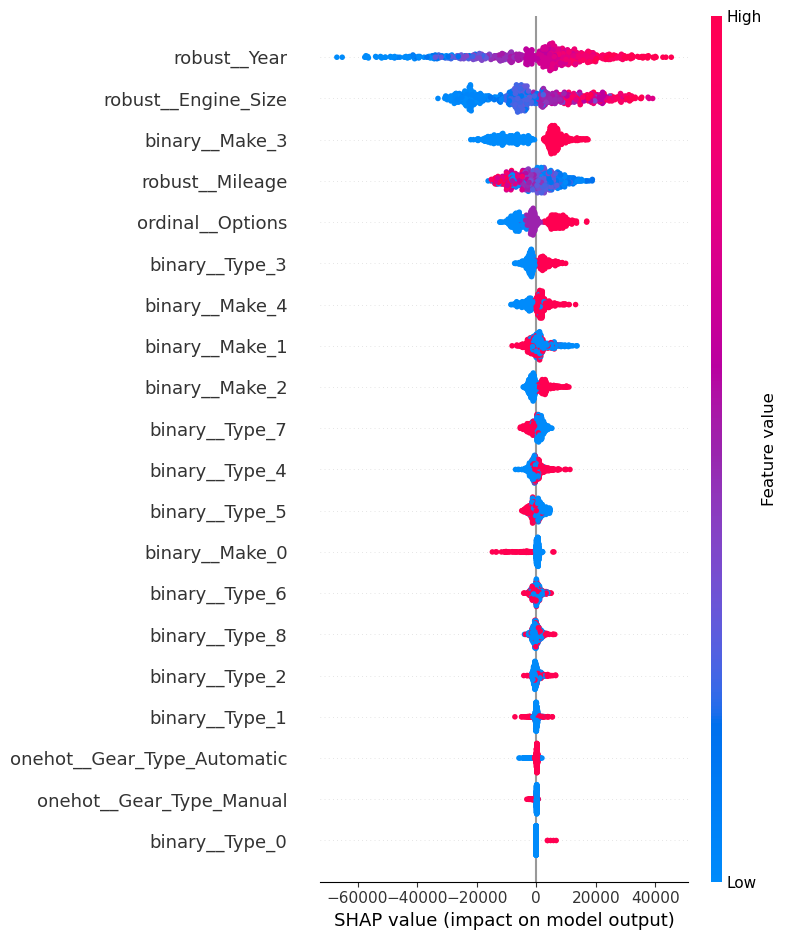

In [79]:
transformed_features = XGBRegressor_tuned.named_steps['preprocessing'].get_feature_names_out()

explainer = shap.TreeExplainer(XGBRegressor_tuned.named_steps['model'])

X_test_transformed = XGBRegressor_tuned.named_steps['preprocessing'].transform(X_test)

shap_values = explainer.shap_values(X_test_transformed)

feature_names = transformed_features

plt.figure(figsize=(15, 10))
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

The SHAP summary plot shows features arranged by their impact, with each point representing a specific prediction. The color gradient from blue to red indicates whether a feature value decreased or increased the predicted price. What makes this visualization particularly valuable, it reveals both the magnitude and direction of each feature's impact.

The vehicle's year of manufacture emerged as the dominant force in price determination, showing a clear pattern: newer vehicles (represented by red dots) consistently push prices higher, while older vehicles (blue dots) pull prices lower. This aligns with the fundamental concept of depreciation but quantifies it precisely for the Saudi market.

Mileage showed a more nuanced pattern. While generally negative in its impact (higher mileage reducing prices), the relationship wasn't strictly linear. Some high-mileage vehicles maintained their value better than others, particularly when combined with desirable features like full option packages or premium brands.

Engine size demonstrated interesting interaction patterns – its impact on price varied significantly depending on the vehicle type and make. This suggests that larger engines don't automatically mean higher prices; their value depends on the market segment they're in.

#### **5. 8. 2. XGBoost Feature Importance**

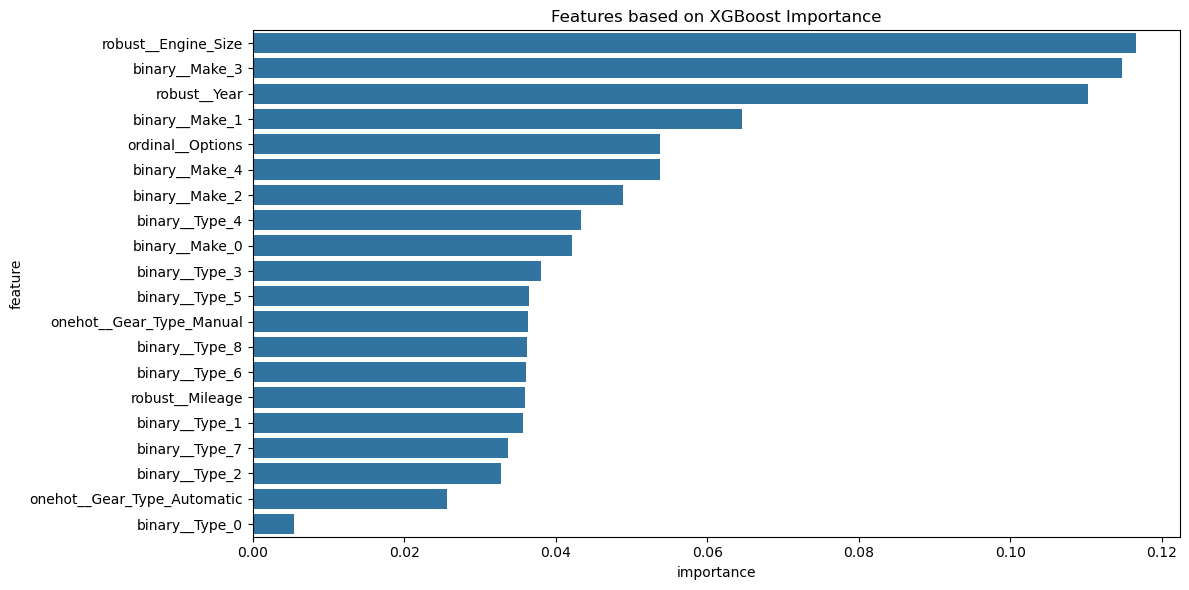

In [80]:
# Get feature importance from XGBoost model
feature_importance = pd.DataFrame({
    'feature': transformed_features,
    'importance': XGBRegressor_tuned.named_steps['model'].feature_importances_
}).sort_values('importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Features based on XGBoost Importance')
plt.tight_layout();

The XGBoost feature importance visualization complements our SHAP analysis by providing a global view of feature significance. Instead of showing individual predictions, this analysis reveals how frequently and effectively each feature is used in making price decisions across all predictions.

The bar chart's ordering tells a clear story about the feature that affect car price:

- Manufacturing year consistently ranks as the most crucial factor, accounting for the largest share of price variations. This makes intuitive sense – age is the primary determinant of depreciation.
- Mileage follows closely as the second most important feature, but its influence is more variable than year. This suggests that while mileage matters significantly, its impact might be moderated by other factors like brand reputation or maintenance history.
- Make and type-related features show substantial importance, reflecting how brand value and vehicle category significantly influence pricing decisions. This helps Syarah understand how different market segments behave differently.
- Equipment levels (Options) maintain meaningful importance, confirming that feature packages contribute significantly to a vehicle's value retention.

## **Conclusion**

Our analysis of Syarah's used car marketplace has yielded valuable insights into the factors that truly drive vehicle prices in Saudi Arabia. Through  data preprocessing, feature engineering, and multiple modeling iterations, we've developed a robust price prediction system that can enhance Syarah's platform functionality and user experience.

The evolution of our model revealed some surprising insights about price determinants in Syarah's marketplace. While our initial hypothesis testing suggested regional differences and manufacturing origins influenced prices, our machine learning models demonstrated these factors were less practically significant than fundamental vehicle characteristics.

Our final XGBoost model, after careful tuning and feature selection, achieved impressive performance metrics with a MAPE of approximately 17.5% and an RMSE of 15,452 SAR. In practical terms for Syarah's users, this means the model can typically predict used car prices within about one-fifth of their actual value – a significant improvement over current subjective pricing methods that often lead to extended negotiation periods and market inefficiencies.

The feature importance analysis uncovered the key factors that truly matter in Syarah's marketplace:

- The feature 'year' emerged as the strongest predictor, revealing that depreciation patterns in the Saudi market follow consistent and predictable trends. This insight can help Syarah develop more transparent pricing guidelines for users.
- 'Mileage' showed a strong negative correlation with price, but in a non-linear fashion. This suggests that the impact of additional kilometers varies depending on the vehicle's overall mileage range.
- 'Engine size' proved moderately important, serving as a reliable indicator of vehicle class and performance level. This helps explain price variations within similar vehicle categories.
- 'Make' and 'Type' demonstrated significant influence, with certain brands commanding consistent premiums. This information can help Syarah better understand market segmentation within their platform.

## **Recommendation**

Based on our analysis, we propose several strategic recommendations for Syarah to enhance their marketplace:

Platform Enhancement:

- Implement our predictive model as an automated pricing tool to provide instant valuations for sellers
- Create a standardized listing format that prioritizes collection of the most influential pricing factors

User Experience Improvements:

- Provide sellers with pricing insights based on similar recent transactions
- Display price trend information based on our model's year and mileage correlations

Business Process Optimization:

- Restructure the listing process to ensure complete information for key pricing factors
- Develop automated quality checks for unusual price-feature combinations

Future Development:

- Research the possibility of incorporating additional data sources such as maintenance history and accident reports

**Save Model**

In [81]:
import pickle

# Save the model
# 1. Save XGBoost tuned model
with open('xgb_tuned_model.pkl', 'wb') as file:
    pickle.dump(XGBRegressor_tuned, file)

# 2. Save transformer
with open('transformer.pkl', 'wb') as file:
    pickle.dump(transformer, file)

# To load the model back
# 1. Load XGBoost tuned model
with open('xgb_tuned_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# 2. Load transformer
with open('transformer.pkl', 'rb') as file:
    loaded_transformer = pickle.load(file)
    
# Verify the loaded model works
# Make predictions with loaded model
y_pred_loaded = loaded_model.predict(X_test)

# Calculate metrics to verify
print("Metrics with loaded model:")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred_loaded)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_loaded))}")

Metrics with loaded model:
MAPE: 0.17546221613883972
RMSE: 15452.372762783067
